In [28]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from scipy.integrate import simpson


from scipy import stats

from multiprocessing import Pool, cpu_count


%load_ext autoreload
%autoreload 2

# regex for number extraction from string
number_pattern =  r'(-?(?:0|[1-9]\d*)(?:\.\d+)?(?:[eE][+-]?\d+)?)'

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':200})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [67]:
# res_df_list = [
#     pd.read_csv('./yeast_network_v_model.csv', index_col=0),
#     pd.read_csv('./bsubtilis_network_v_model.csv', index_col=0),
#     pd.read_csv('./arabidopsis_network_v_model.csv', index_col=0),
#     pd.read_csv('./mouse_bulk_network_v_model.csv', index_col=0)
# ]

tf_df_list = [
    pd.read_csv('../output/network_model/yeast_tf.csv', index_col=0, names=['tf']),
    pd.read_csv('../output/network_model/bsubtilis_tf.csv', index_col=0, names=['tf']),
    pd.read_csv('../output/network_model/arabidopsis_tf.csv', index_col=0, names=['tf']),
    pd.read_csv('../output/network_model/mouse_tf.csv', index_col=0, names=['tf']),
]

res_df_list = [
    pd.read_csv('../output/network_model/yeast_all_tf_high_var_target_new.csv.gz', index_col=0, compression='gzip'),
    pd.read_csv('../output/network_model/bsubtilis_all_tf_high_var_target_new.csv.gz', index_col=0, compression='gzip'),
    pd.read_csv('../output/network_model/arabidopsis_all_tf_high_var_target_new.csv.gz', index_col=0, compression='gzip'),
    pd.read_csv('../output/network_model/mouse_all_tf_high_var_target_new.csv.gz', index_col=0, compression='gzip'),
]

species_names = ['Yeast', 'B.subtilis', 'Arabidopsis', 'Mouse']
species_file_names = ['yeast', 'bsubtilis', 'arabidopsis', 'mouse']

filtered_df_list = [res_df[res_df['test_std'] > 5] for res_df in res_df_list]



In [55]:
for df in res_df_list:
    minimal_set_sizes = []
    small_size_set = []
    for num_list, efron_size in zip(df['rf_efron_complementary_feature_num_list'], df['rf_efron_feature_num']):
        minimal_set_sizes.append(int(efron_size))
        if (int(efron_size) < 10):
            small_size_set.append(int(efron_size))
    print(1.0*len(small_size_set)/len(minimal_set_sizes))

0.6543535620052771
0.6984993178717599
0.6828919112383679
0.5451612903225806


In [78]:
for df in res_df_list:
    print(df['rf_efron_feature_num'].median())

3.0
2.0
3.0
5.0


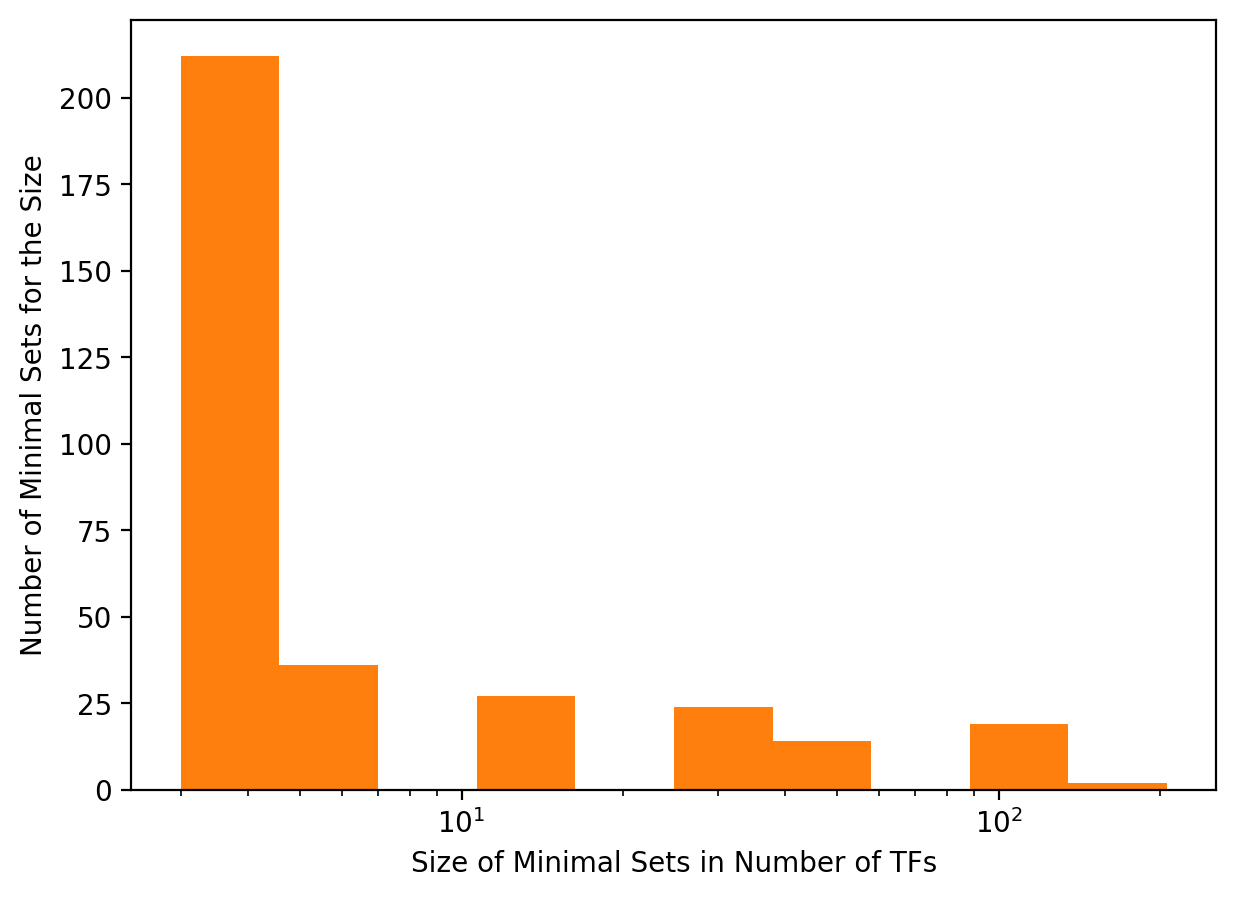

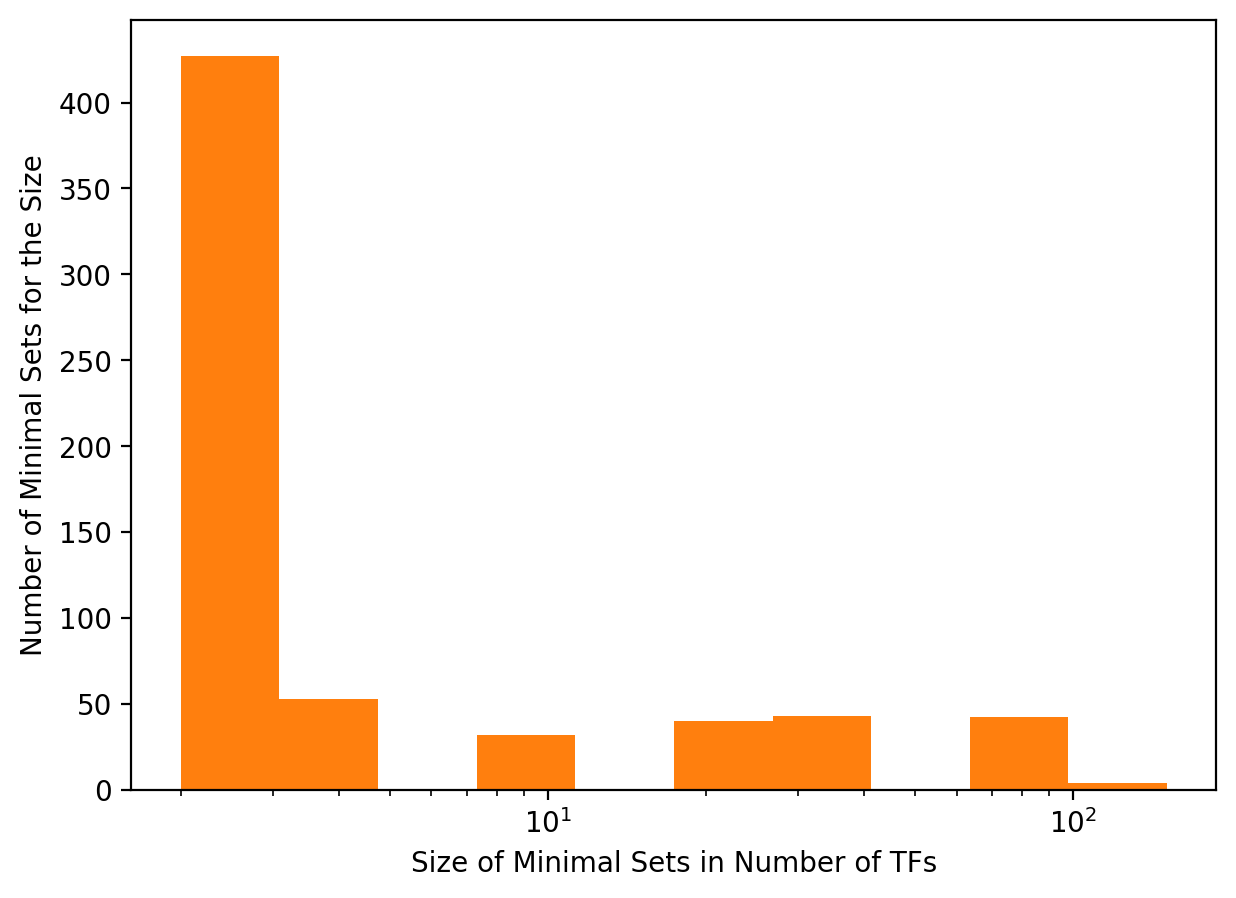

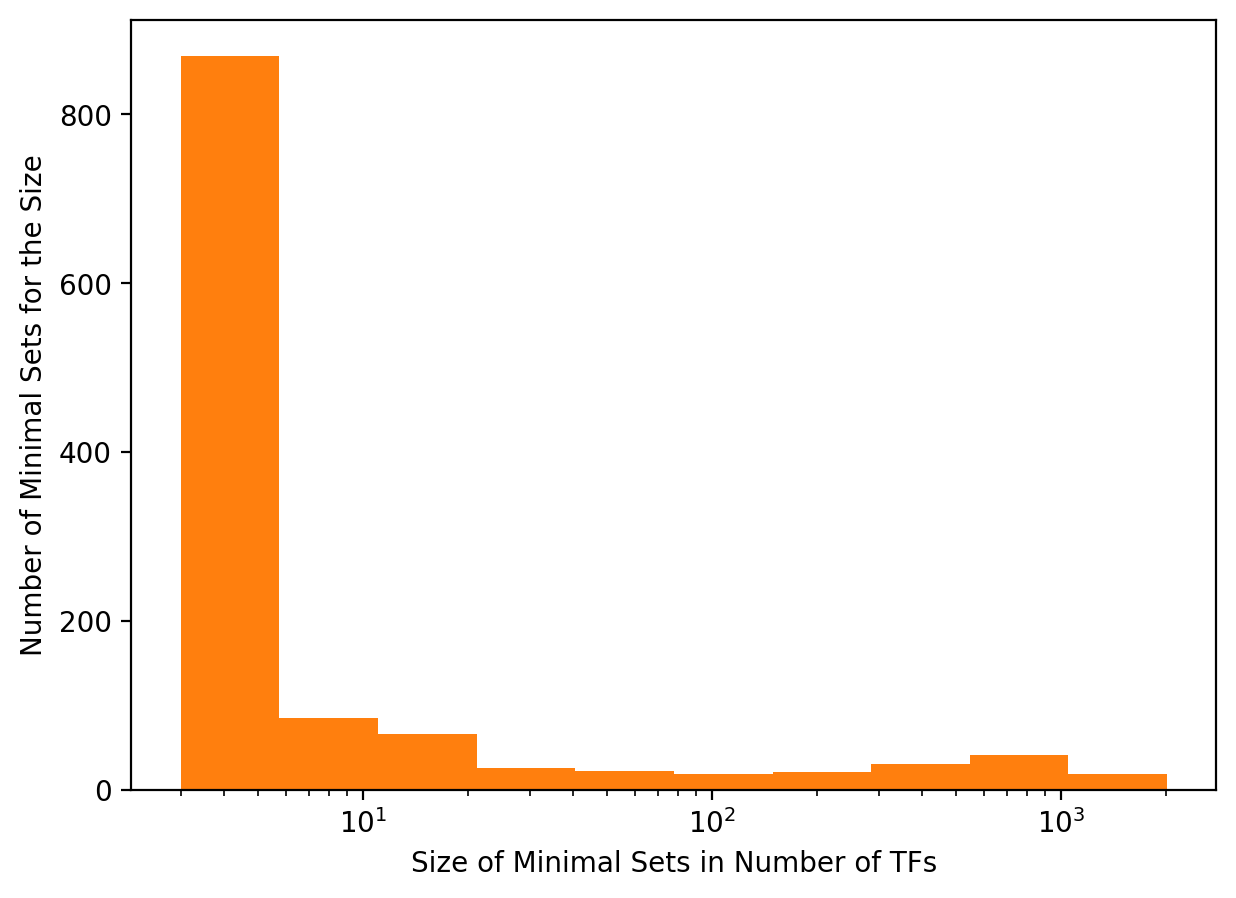

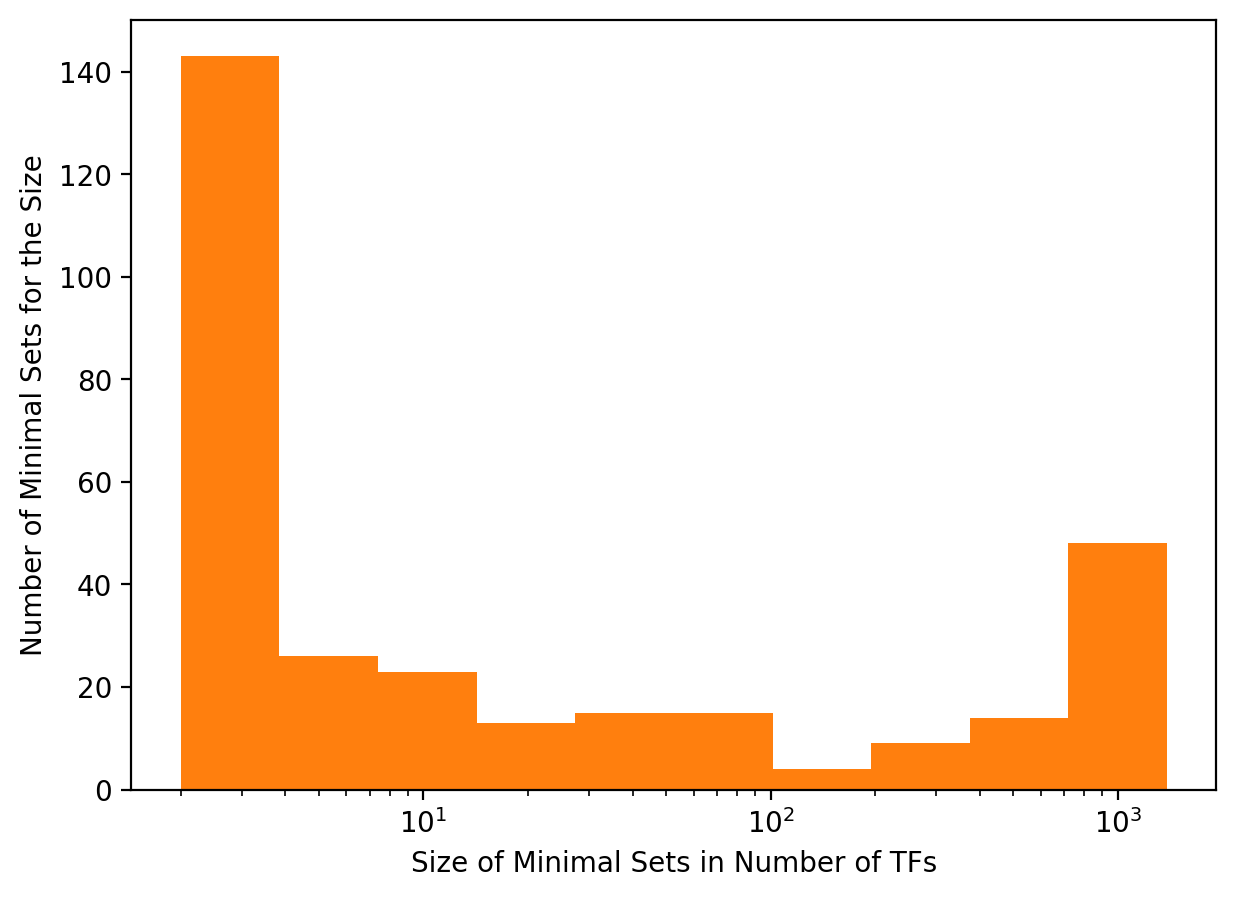

In [242]:

for df, species_name in zip(res_df_list, species_names):
    minimal_set_sizes = []
    for num_list, efron_size in zip(df['rf_efron_complementary_feature_num_list'], df['rf_efron_feature_num']):
        minimal_set_sizes.append(int(efron_size))
    hist, bins = np.histogram(minimal_set_sizes, bins=10)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.hist(minimal_set_sizes, bins=logbins, color=colors[1])
    ax.set_xscale('log')
    ax.set(xlabel='Size of Minimal Sets in Number of TFs')
    ax.set(ylabel='Number of Minimal Sets for the Size')
    # plt.title('Model Performance on '+ species_name +' Target Genes')
    # plt.legend()
    plt.show()

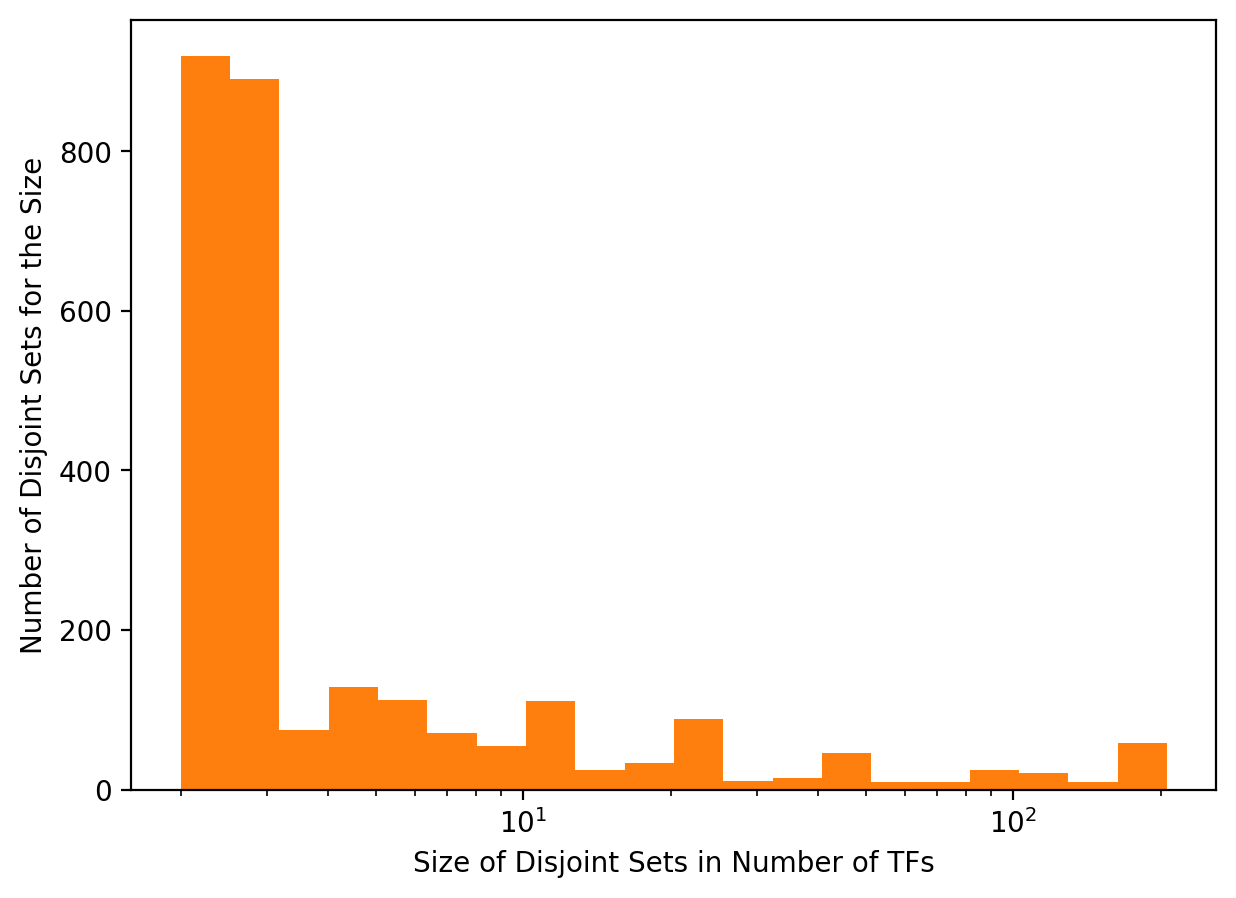

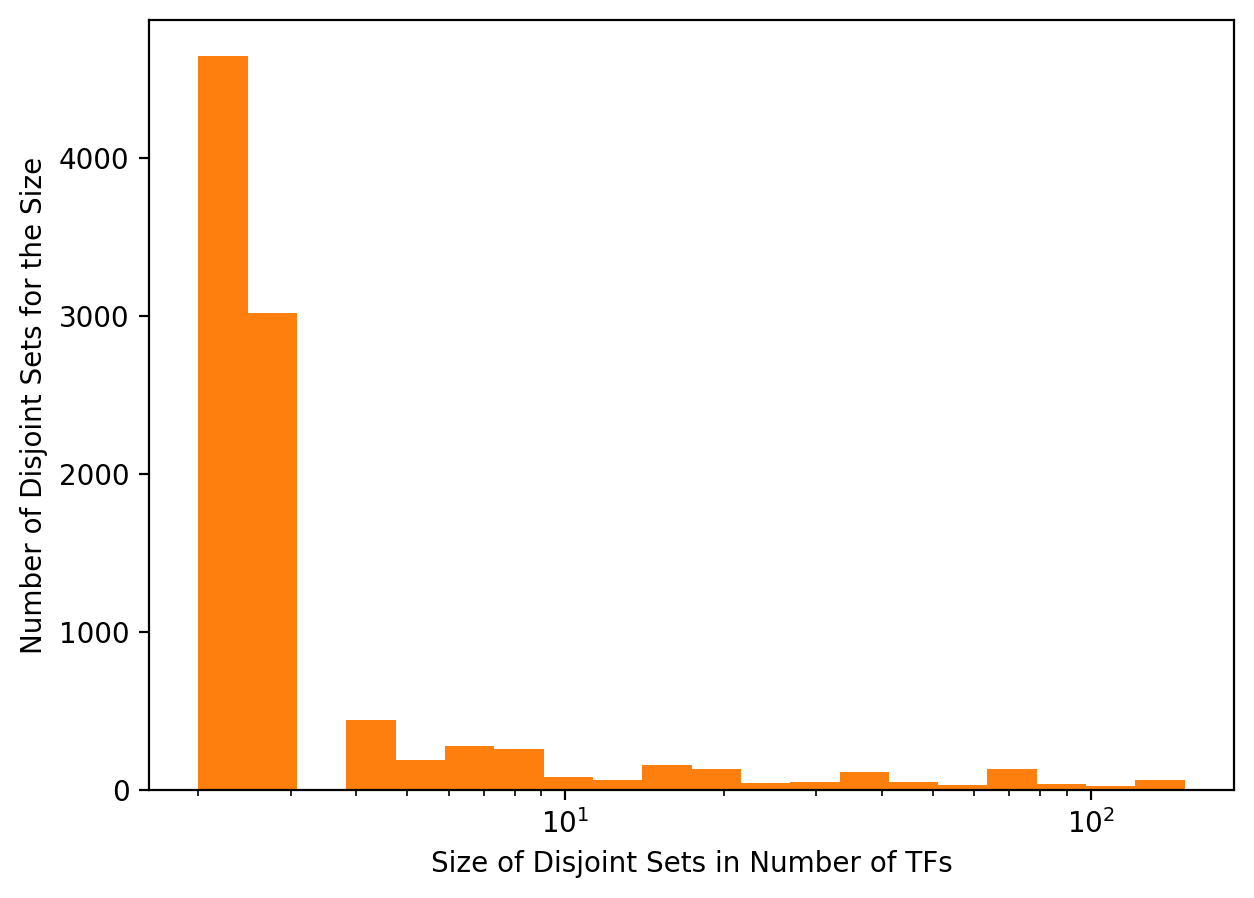

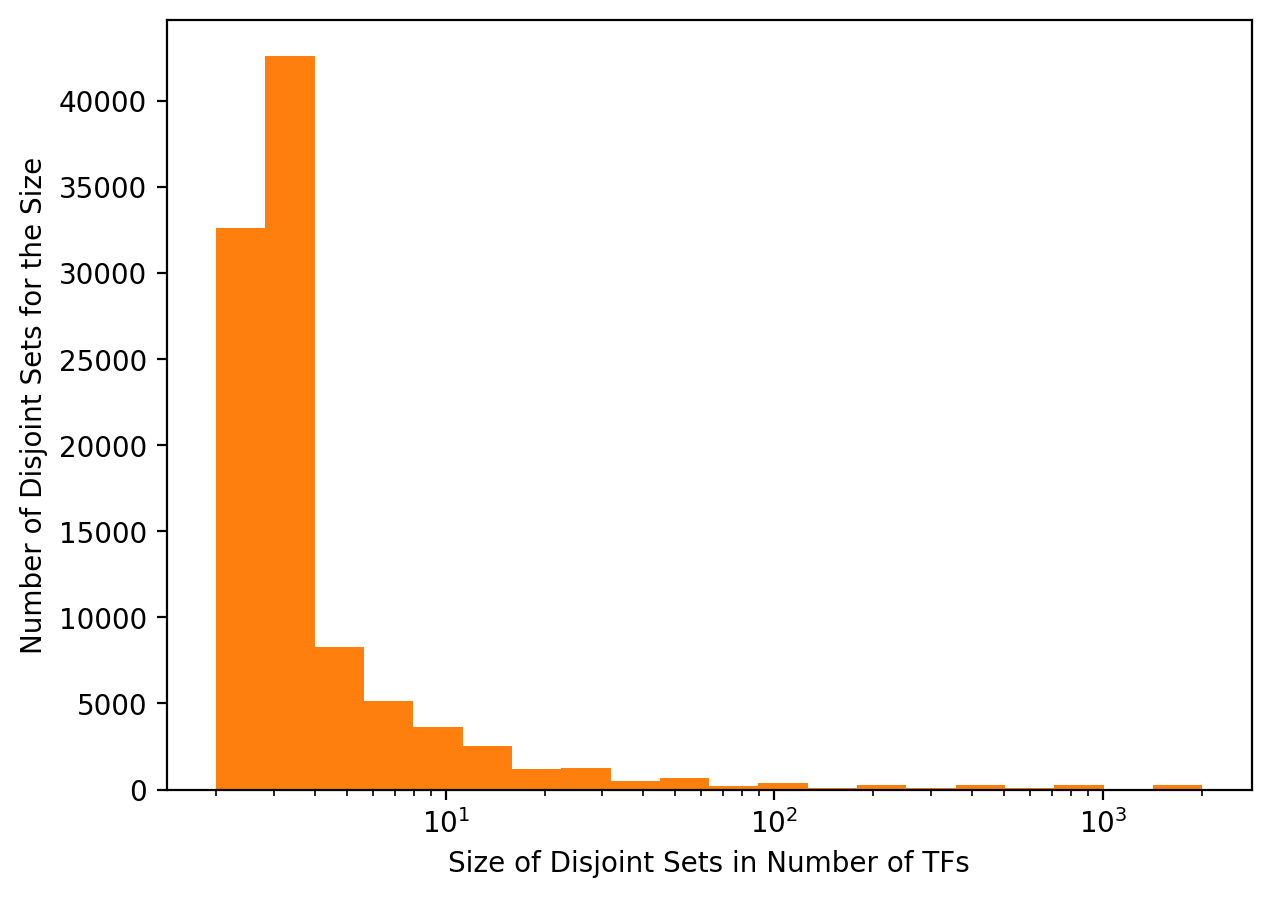

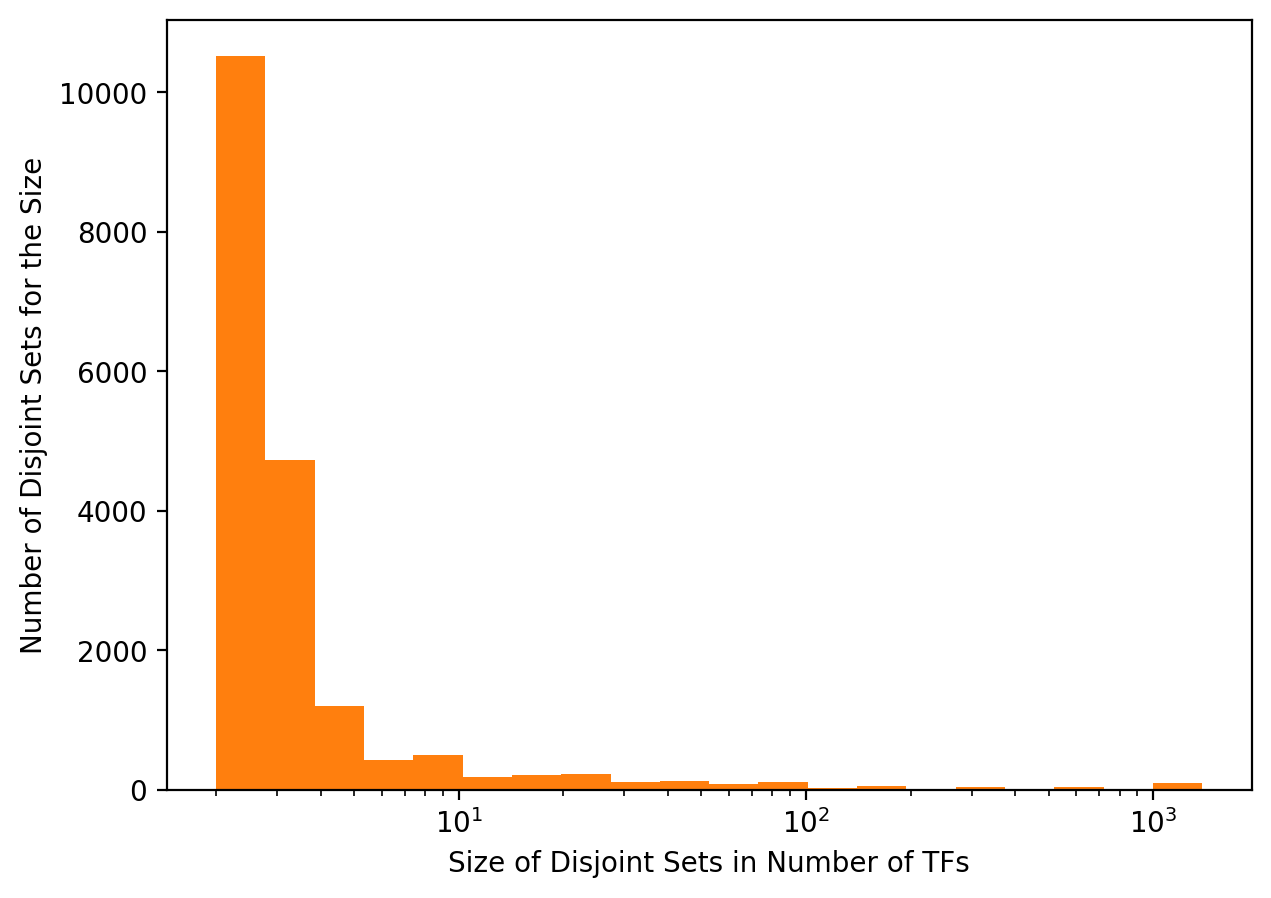

In [235]:

for df, species_name in zip(res_df_list, species_names):
    disjoint_set_sizes = []
    for num_list, efron_size in zip(df['rf_efron_complementary_feature_num_list'], df['rf_efron_feature_num']):
        disjoint_set_sizes.append(int(efron_size))
        if isinstance(num_list, str):
            size_list = [int(i) for i in num_list.split(', ')]
            size_list= list(filter(lambda a: a != 1, size_list))
            disjoint_set_sizes.extend(size_list)
    hist, bins = np.histogram(disjoint_set_sizes, bins=20)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.hist(disjoint_set_sizes, bins=logbins, color=colors[1])
    ax.set_xscale('log')
    ax.set(xlabel='Size of Disjoint Sets in Number of TFs')
    ax.set(ylabel='Number of Disjoint Sets for the Size')
    # plt.title('Model Performance on '+ species_name +' Target Genes')
    # plt.legend()
    plt.show()

0.8496042216358839
0.519781718963165
0.41302791696492486
0.6064516129032258


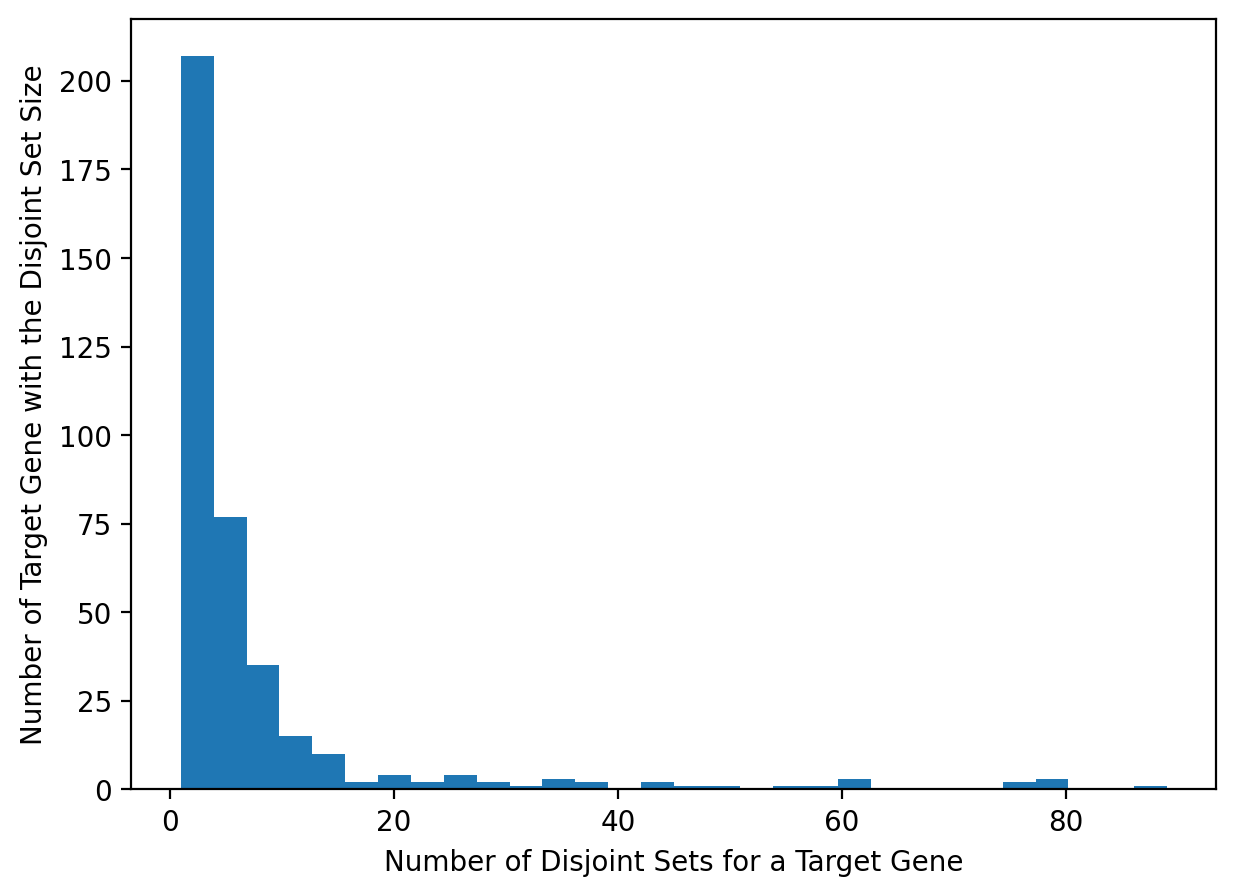

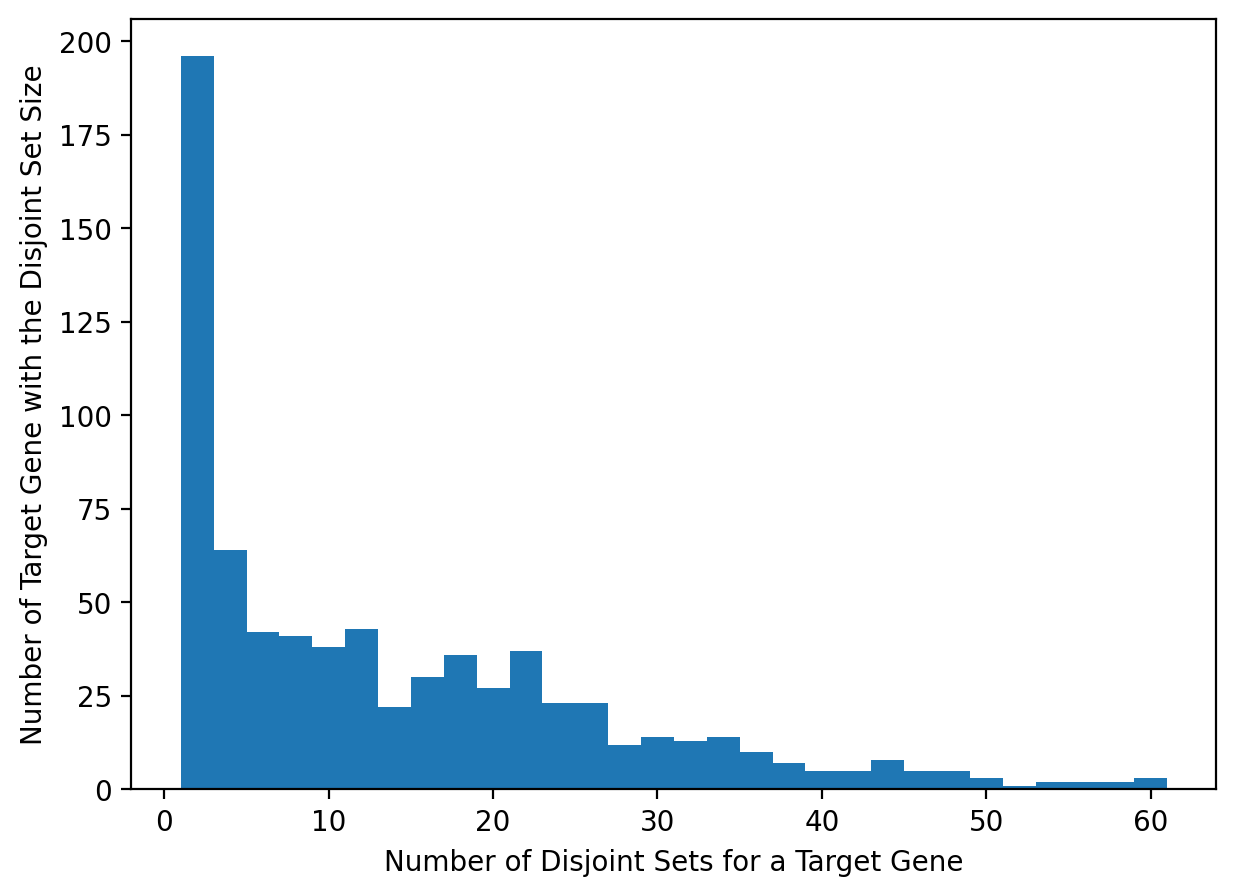

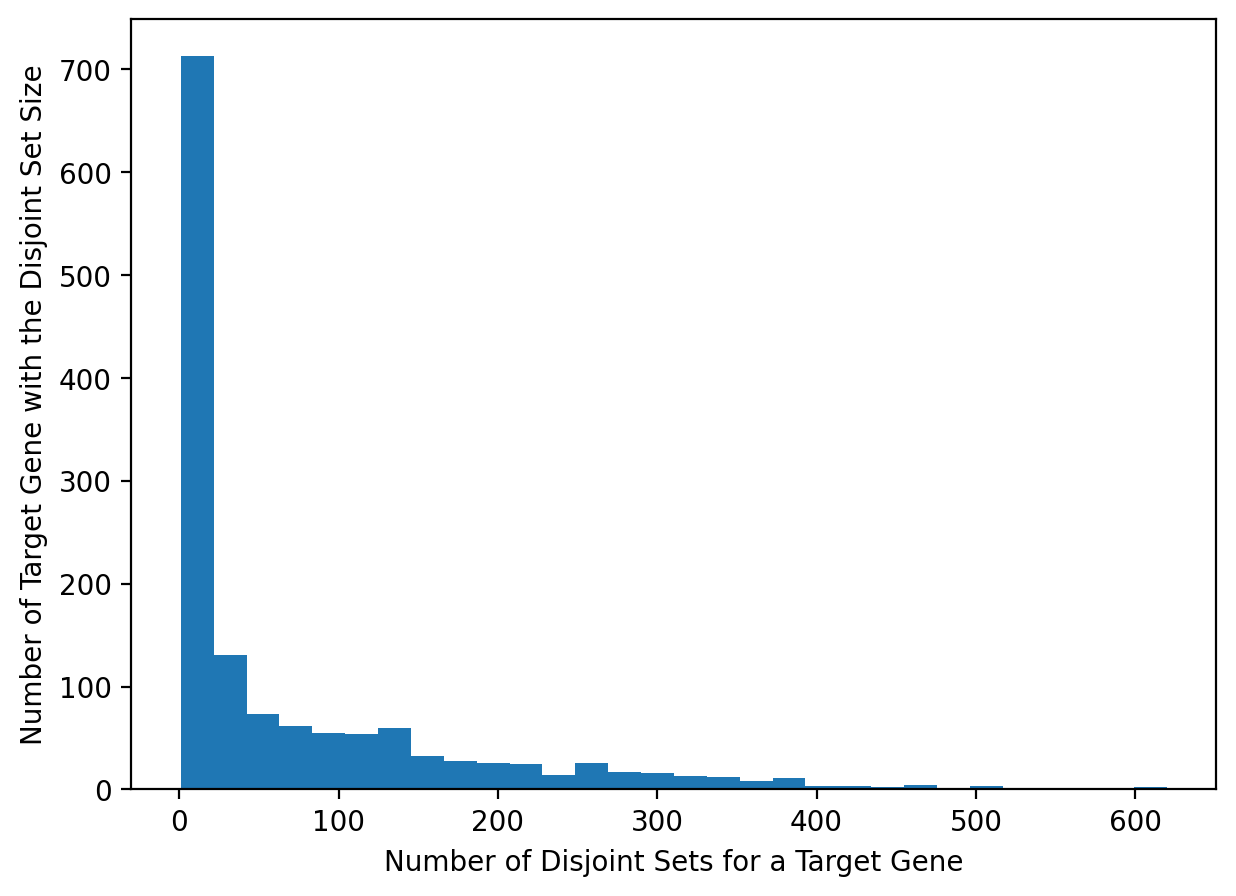

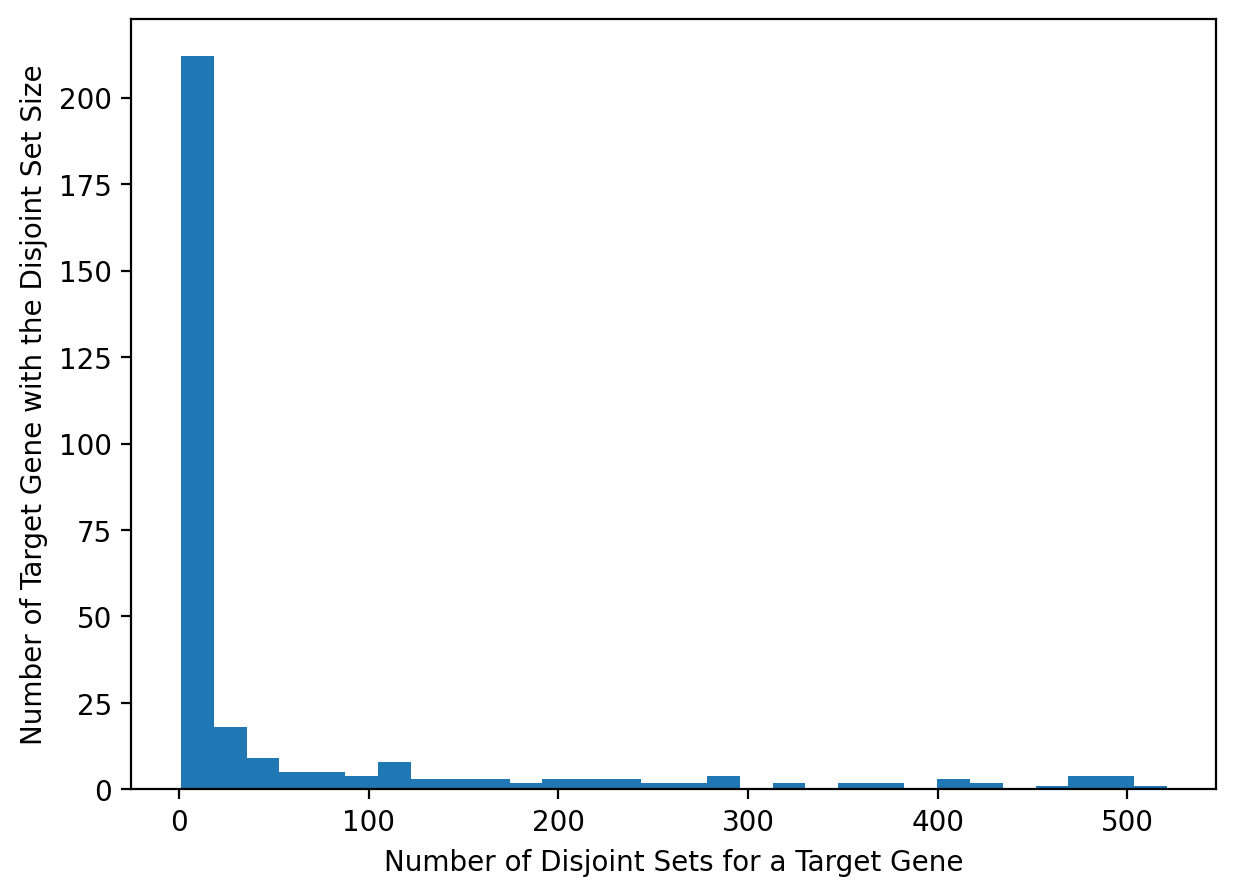

In [76]:
for df, species_name in zip(res_df_list, species_file_names):
    disjoint_set_count = []
    for num_list in df['rf_efron_complementary_feature_num_list']:
        if isinstance(num_list, str):
            disjoint_set_count.append(len(num_list.split(', '))+1)
        else:
            disjoint_set_count.append(1)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.hist(disjoint_set_count, bins=30)
    ax.set(xlabel='Number of Disjoint Sets for a Target Gene')
    ax.set(ylabel='Number of Target Gene with the Disjoint Set Size')
    # plt.title('Model Performance on '+ species_name +' Target Genes')
    print(1.0*sum(i < 11 for i in disjoint_set_count)/len(disjoint_set_count))
    # plt.legend()
    plt.savefig('./plot_output/disjoint_sets_count/'+species_name+'.pdf', bbox_inches='tight')

In [227]:
test_df = res_df_list[3]
df_length = len(test_df)
tf_df = tf_df_list[3]
disjoint_set_dict = {}
for i in range(df_length):
    i_sets = []
    i_sets.append(set([int(idx) for idx in test_df.iloc[i]['rf_efron_features'].split('; ')]))
    complementary_sets = test_df.iloc[i]['rf_efron_complementary_features_list']
    if isinstance(complementary_sets, str):
        complementary_sets = complementary_sets.split(', ')
        complementary_sets = [set([int(idx) for idx in s.split('; ')]) for s in complementary_sets]
        i_sets.extend(complementary_sets)
    
    disjoint_set_dict[i] = []
    for s in i_sets:
        if len(s) < 5:
            disjoint_set_dict[i].append(s)

In [ ]:
def find():
    for i in tqdm(range(df_length)):
        if (len(disjoint_set_dict[i]) < 2):
            continue
        for j in range(i+1, df_length):
            if (len(disjoint_set_dict[i]) < 2):
                continue
            for set_m in disjoint_set_dict[i]:
                for set_n in disjoint_set_dict[j]:
                    if (set_m == set_n):
                        print('common_set:')
                        print(tf_df.index[list(set_n)])
                        print(test_df.index[i])
                        for s in disjoint_set_dict[i]:
                            print(tf_df.index[list(s)])
                        print(test_df.index[j])
                        for s in disjoint_set_dict[j]:
                            print(tf_df.index[list(s)])
                        return 0

find()

In [31]:
res_df_list[1].columns

Index(['rf_score', 'linear_score', 'gs_rf_score', 'gs_linear_score',
       'rf_with_linear_top_features_score',
       'linear_with_rf_top_features_score', 'rf_rmse', 'linear_rmse',
       'gs_rf_rmse', 'gs_linear_rmse', 'rf_with_linear_top_features_rmse',
       'linear_with_rf_top_features_rmse', 'rf_with_top_features_score',
       'linear_with_top_features_score', 'rf_with_top_features_rmse',
       'linear_with_top_features_rmse', 'rf_top_feature_num',
       'linear_top_feature_num', 'rf_top_features_gs_overlap',
       'linear_top_features_gs_overlap', 'rf_linear_top_features_overlap',
       'gs_edge_num', 'test_var', 'test_std', 'pca_rf_score', 'pca_rf_rmse',
       'rf_efron_feature_num', 'rf_efron_complementary_feature_num_list',
       'rf_efron_rmse', 'rf_efron_complementary_rmse_list',
       'rf_efron_features', 'rf_efron_complementary_features_list',
       'rf_top_tf_same_count_as_gs_score', 'rf_top_tf_same_count_as_gs_rmse'],
      dtype='object')

In [32]:
compare_list = ['rf_rmse', 
                'linear_rmse', 
                'gs_rf_rmse', 
                'gs_linear_rmse', 
                'rf_top_tf_same_count_as_gs_rmse', 
                # 'linear_with_top_features_rmse', 
                'rf_efron_rmse']
                # 'linear_dynamic_efron_rmse']

compare_name_list = ['RF with all TFs',
                     'Linear with all TFs',
                     'RF with GS TFs',
                     'Linear with GS TFs',
                     'RF with top TFs',
                    #  'Linear with top TFs (95% top)',
                     'RF with Minimal TF set']
                    #  'Linear with top TFs (Efron)']

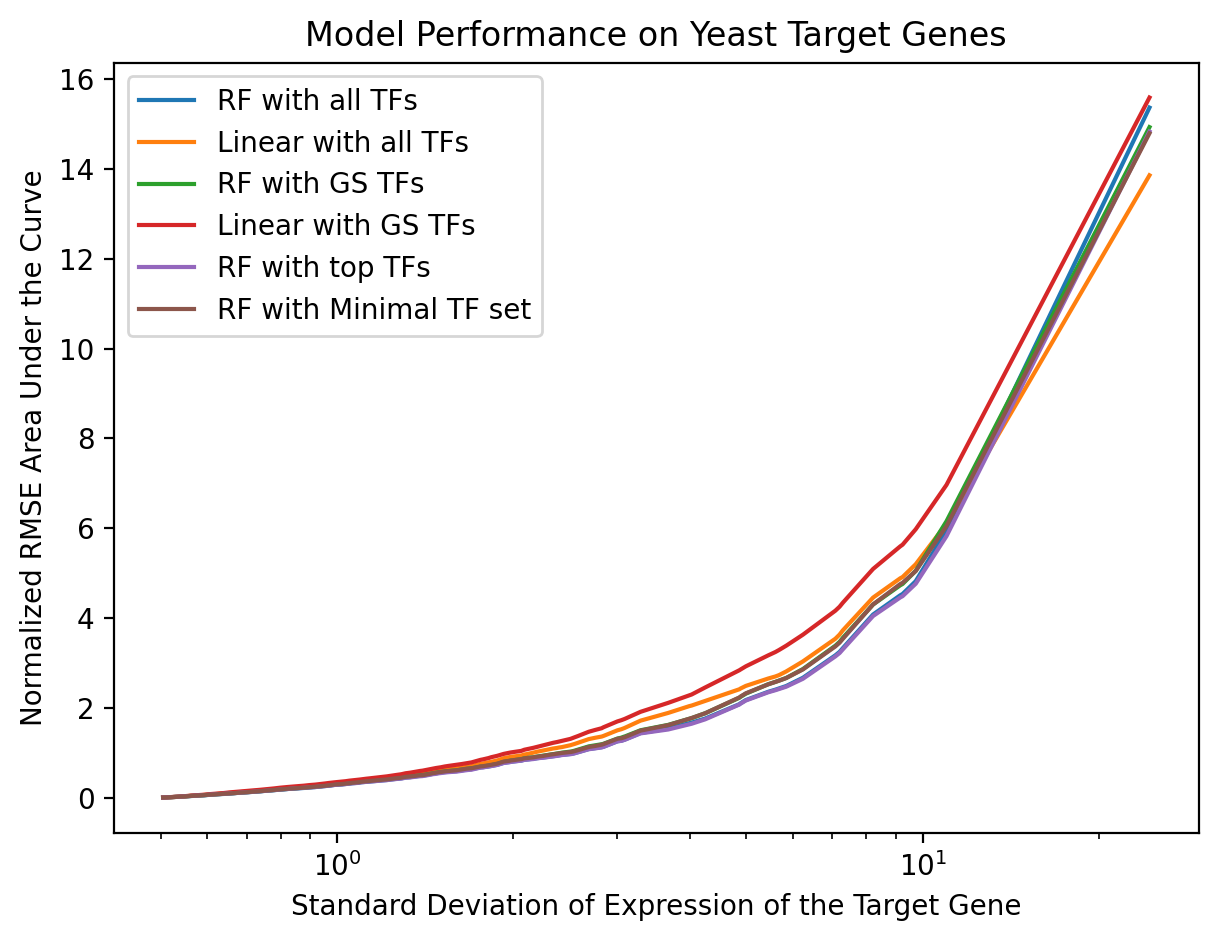

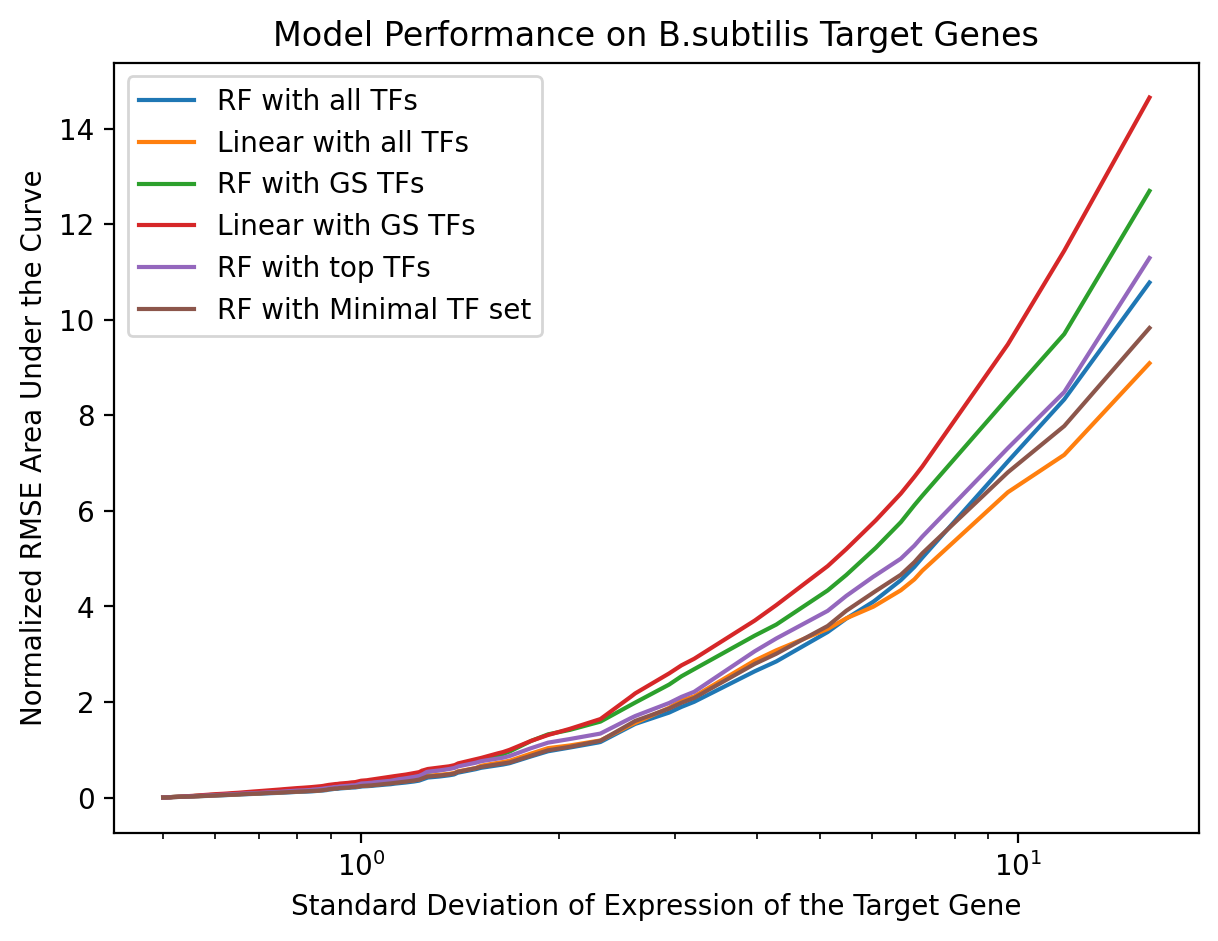

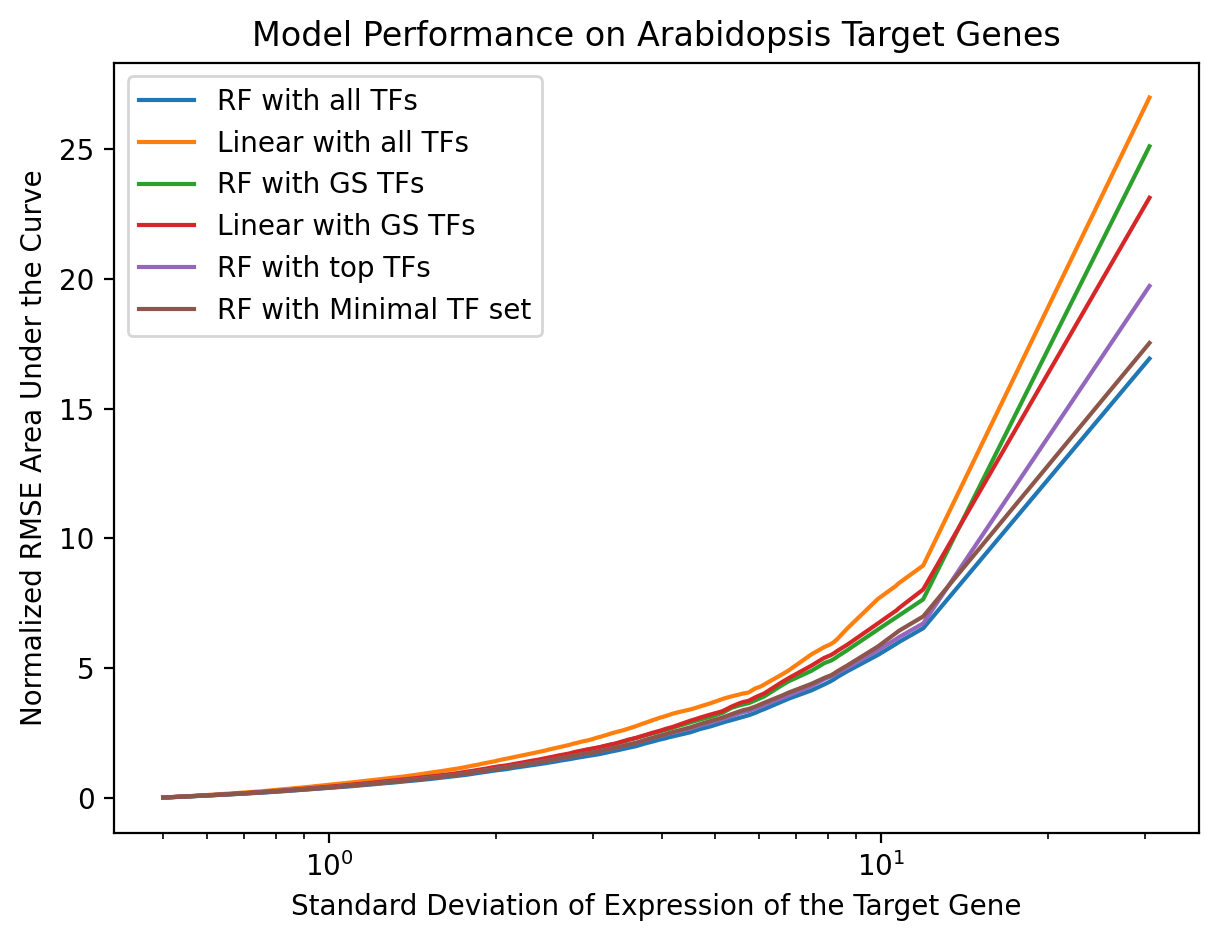

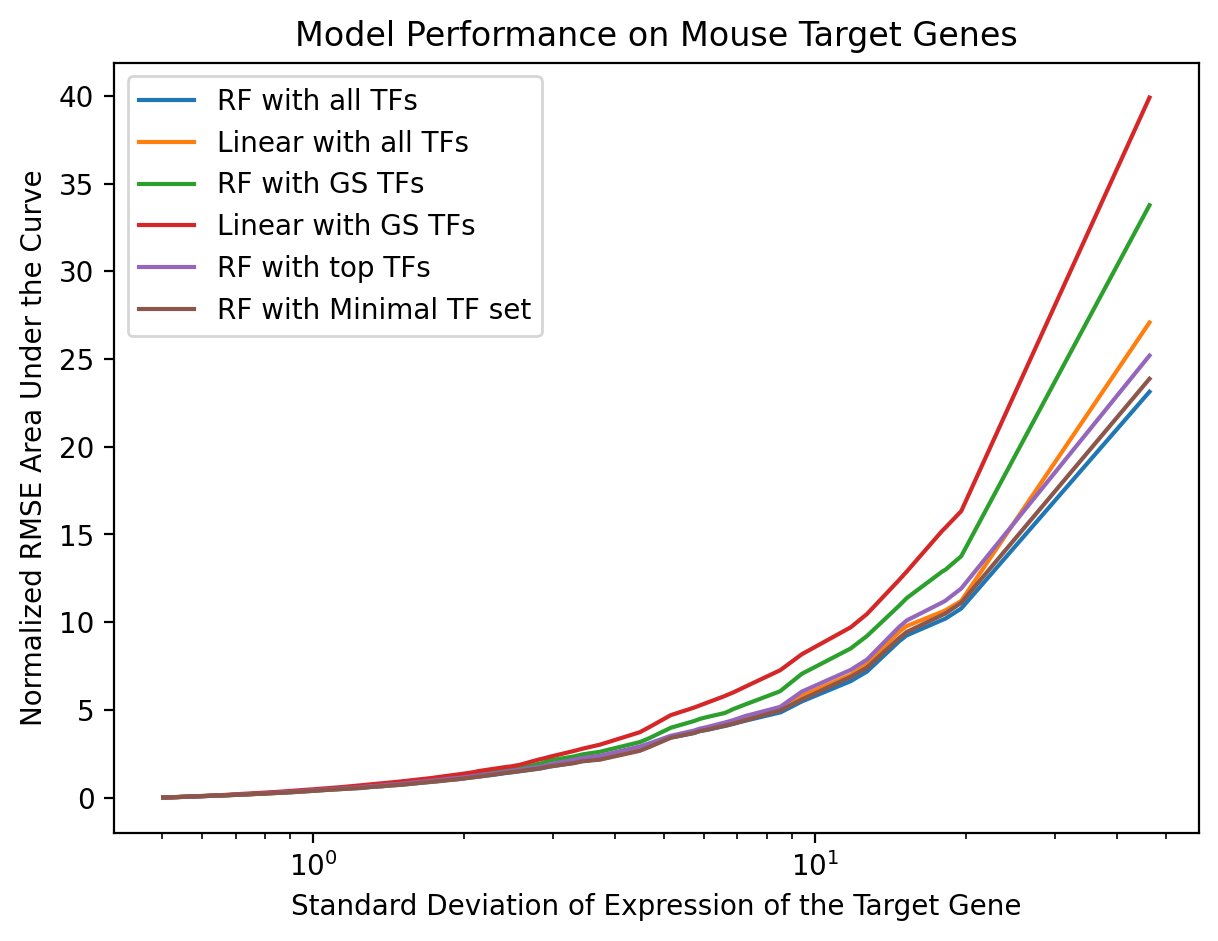

In [33]:
for df, species_name in zip(res_df_list, species_names):

    df = df.sort_values('test_std')
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xscale('log')
    x = df['test_std']

    for model, model_name in zip(compare_list, compare_name_list):
        y = df[model]
        y_norm = y/x
        auc = [np.trapz(y_norm[:i+1], x[:i+1]) for i in range(len(x))]
        ax.plot(x, auc, label=model_name)
    ax.set(xlabel='Standard Deviation of Expression of the Target Gene')
    ax.set(ylabel='Normalized RMSE Area Under the Curve')
    plt.title('Model Performance on '+ species_name +' Target Genes')
    plt.legend()
    plt.show()

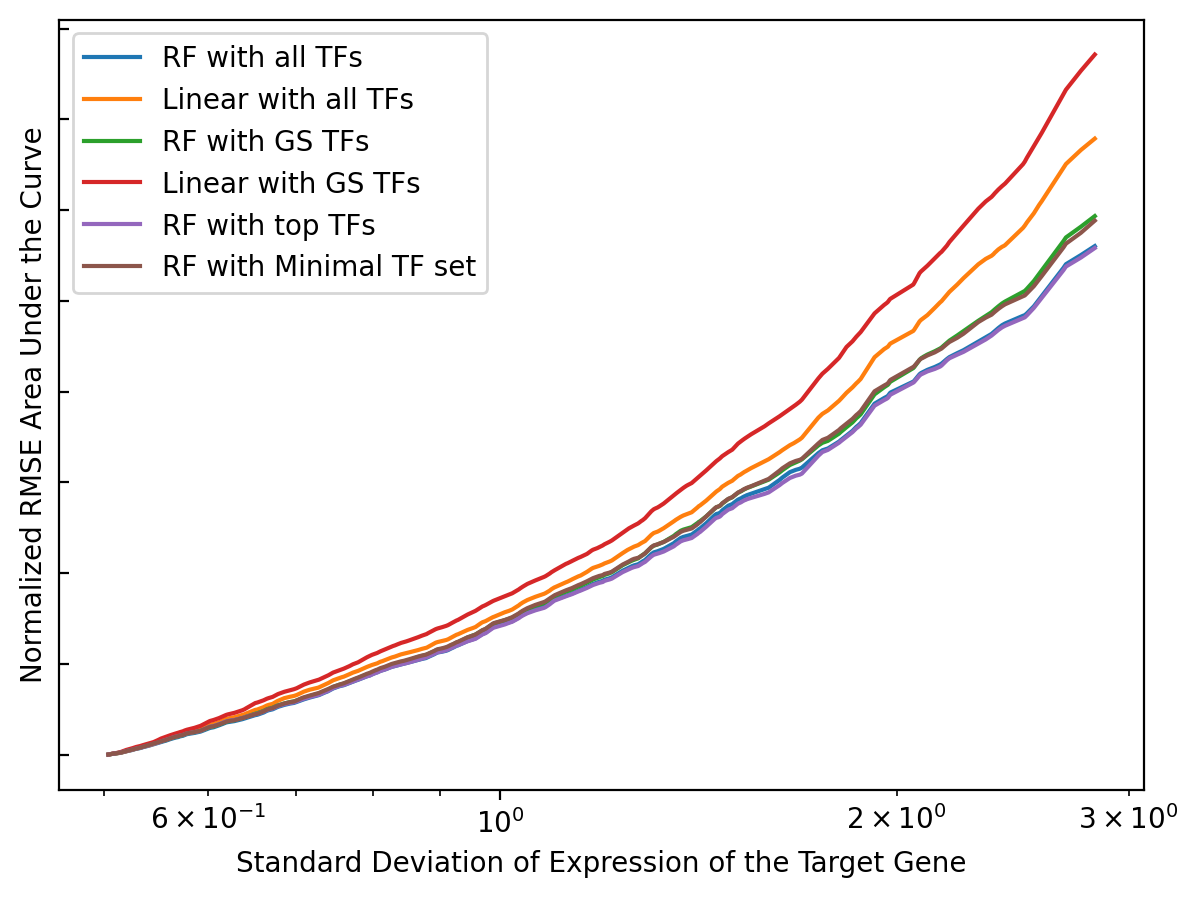

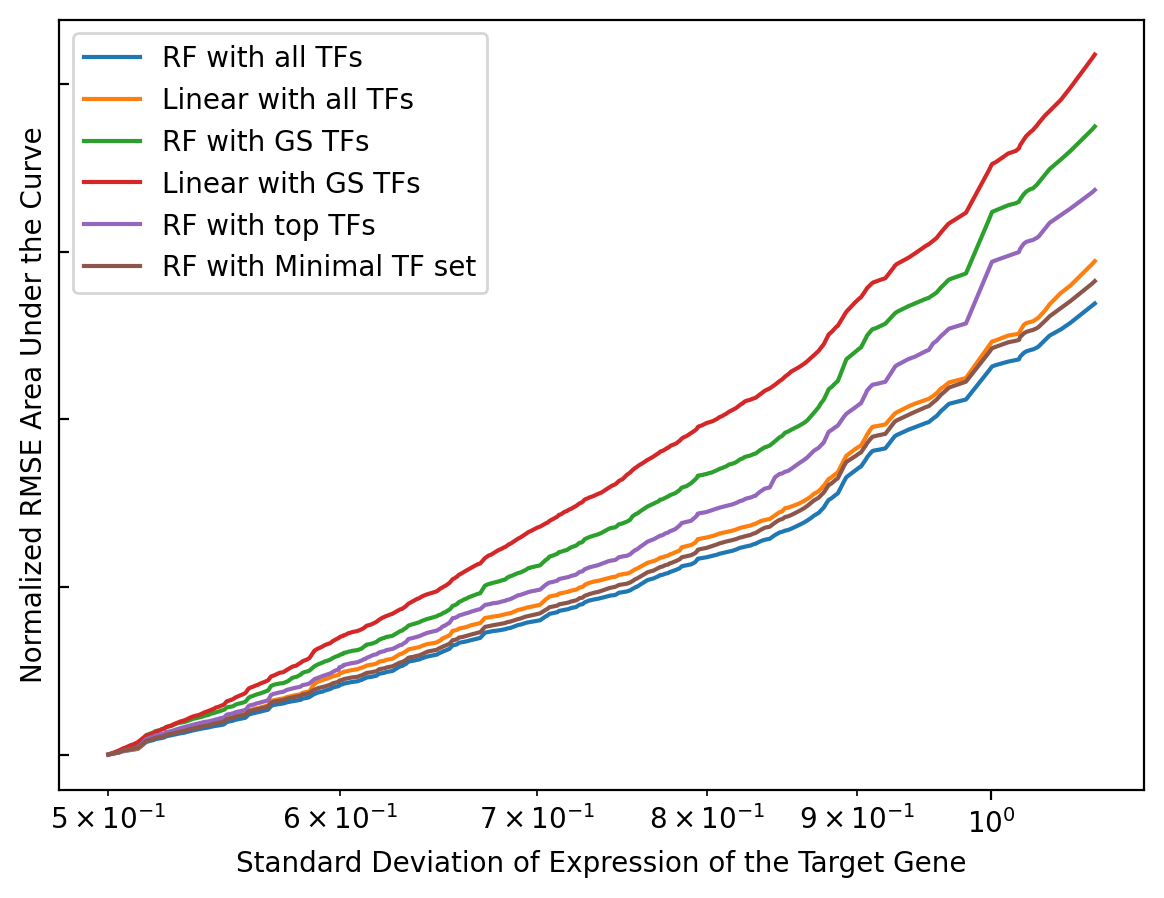

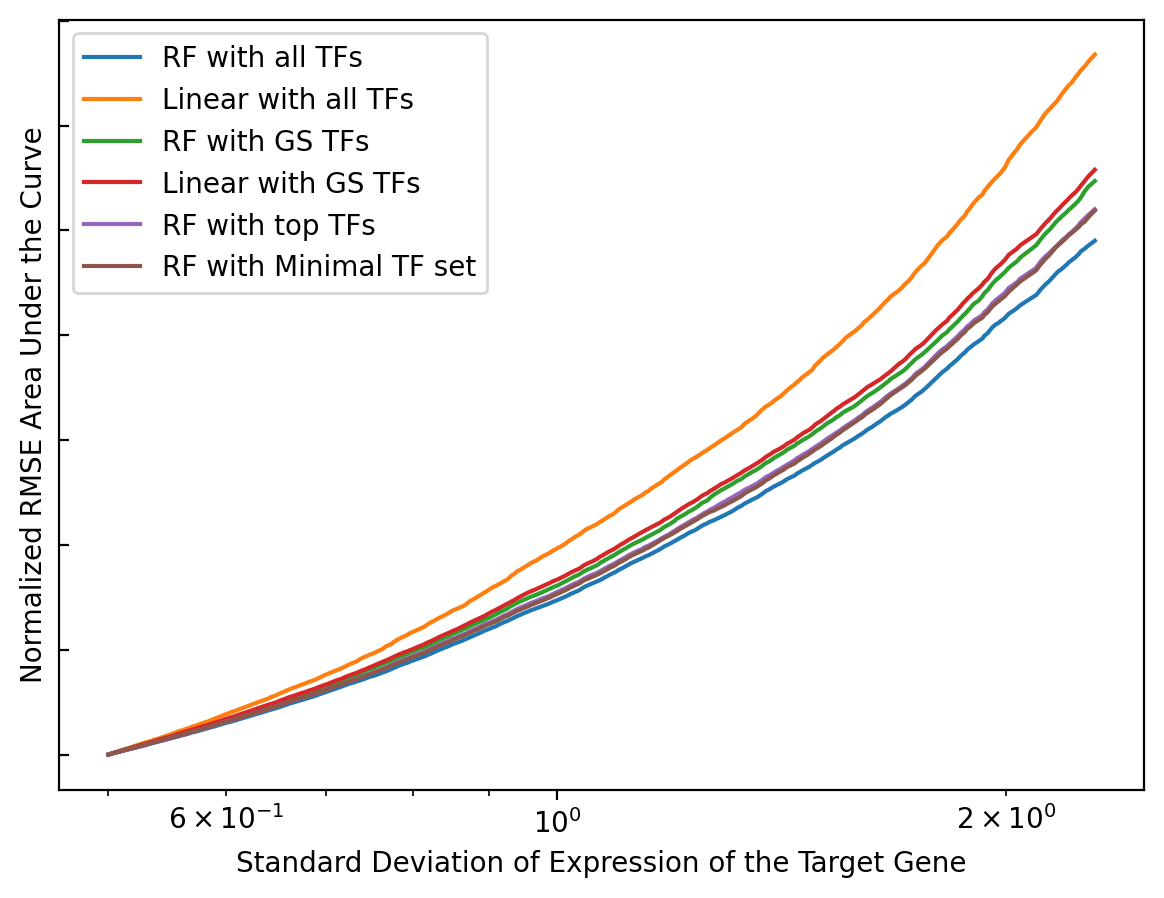

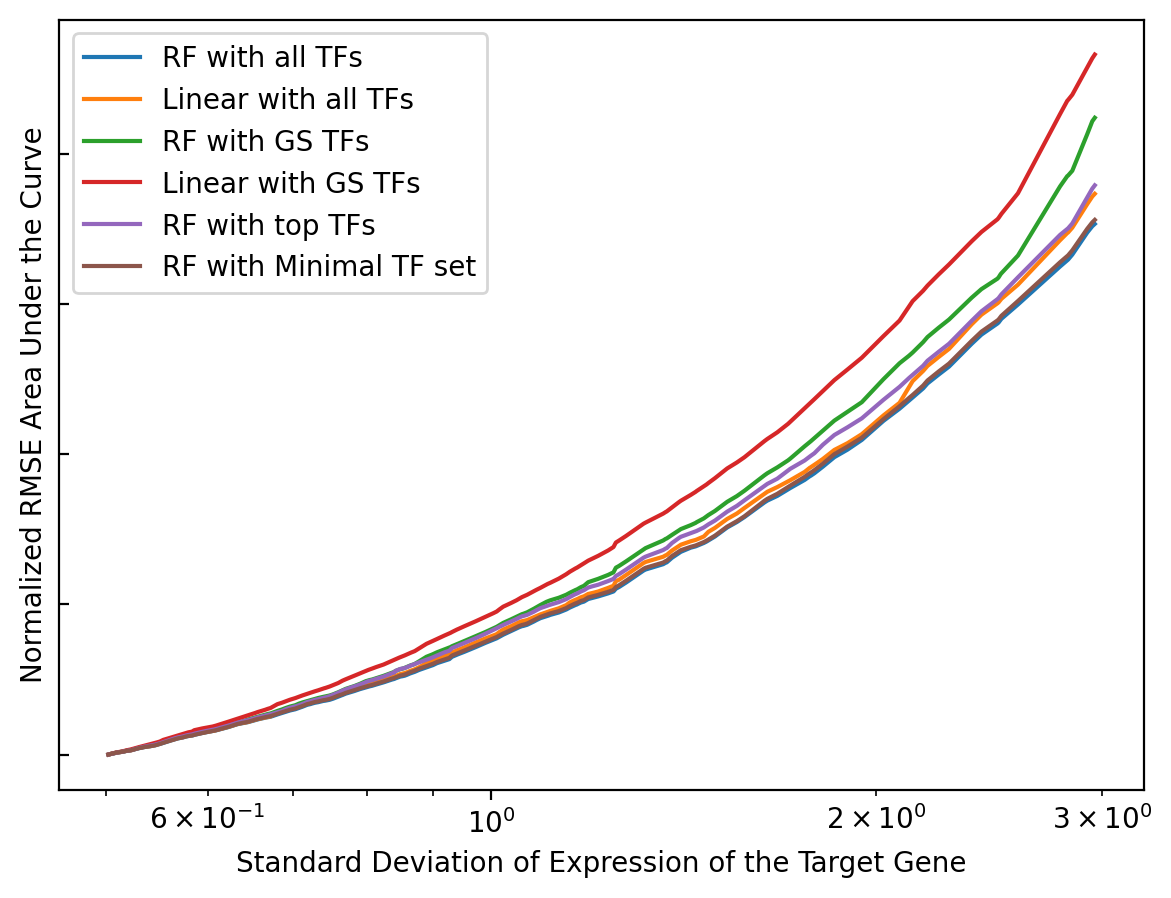

In [54]:
for df, species_name in zip(res_df_list, species_names):

    df = df.sort_values('test_std')
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xscale('log')
    df = df.sort_values('test_std').head(int(len(df)*(0.9)))
    x = df['test_std']

    for model, model_name in zip(compare_list, compare_name_list):
        y = df[model]
        y_norm = y/x
        auc = [np.trapz(y_norm[:i+1], x[:i+1]) for i in range(len(x))]
        ax.plot(x, auc, label=model_name)
    ax.set(xlabel='Standard Deviation of Expression of the Target Gene')
    ax.set(ylabel='Normalized RMSE Area Under the Curve')
    ax.tick_params(axis="y",direction="in", pad=-22, labelleft=False)
    # ax.tick_params(axis="x",direction="in", pad=-15)
    # plt.title('Model Performance on '+ species_name +' Target Genes')
    plt.legend(loc="best")
    # plt.show()
    plt.savefig('./plot_output/rmse_auc/'+species_name+'.pdf', bbox_inches='tight')

In [ ]:
for i in range()

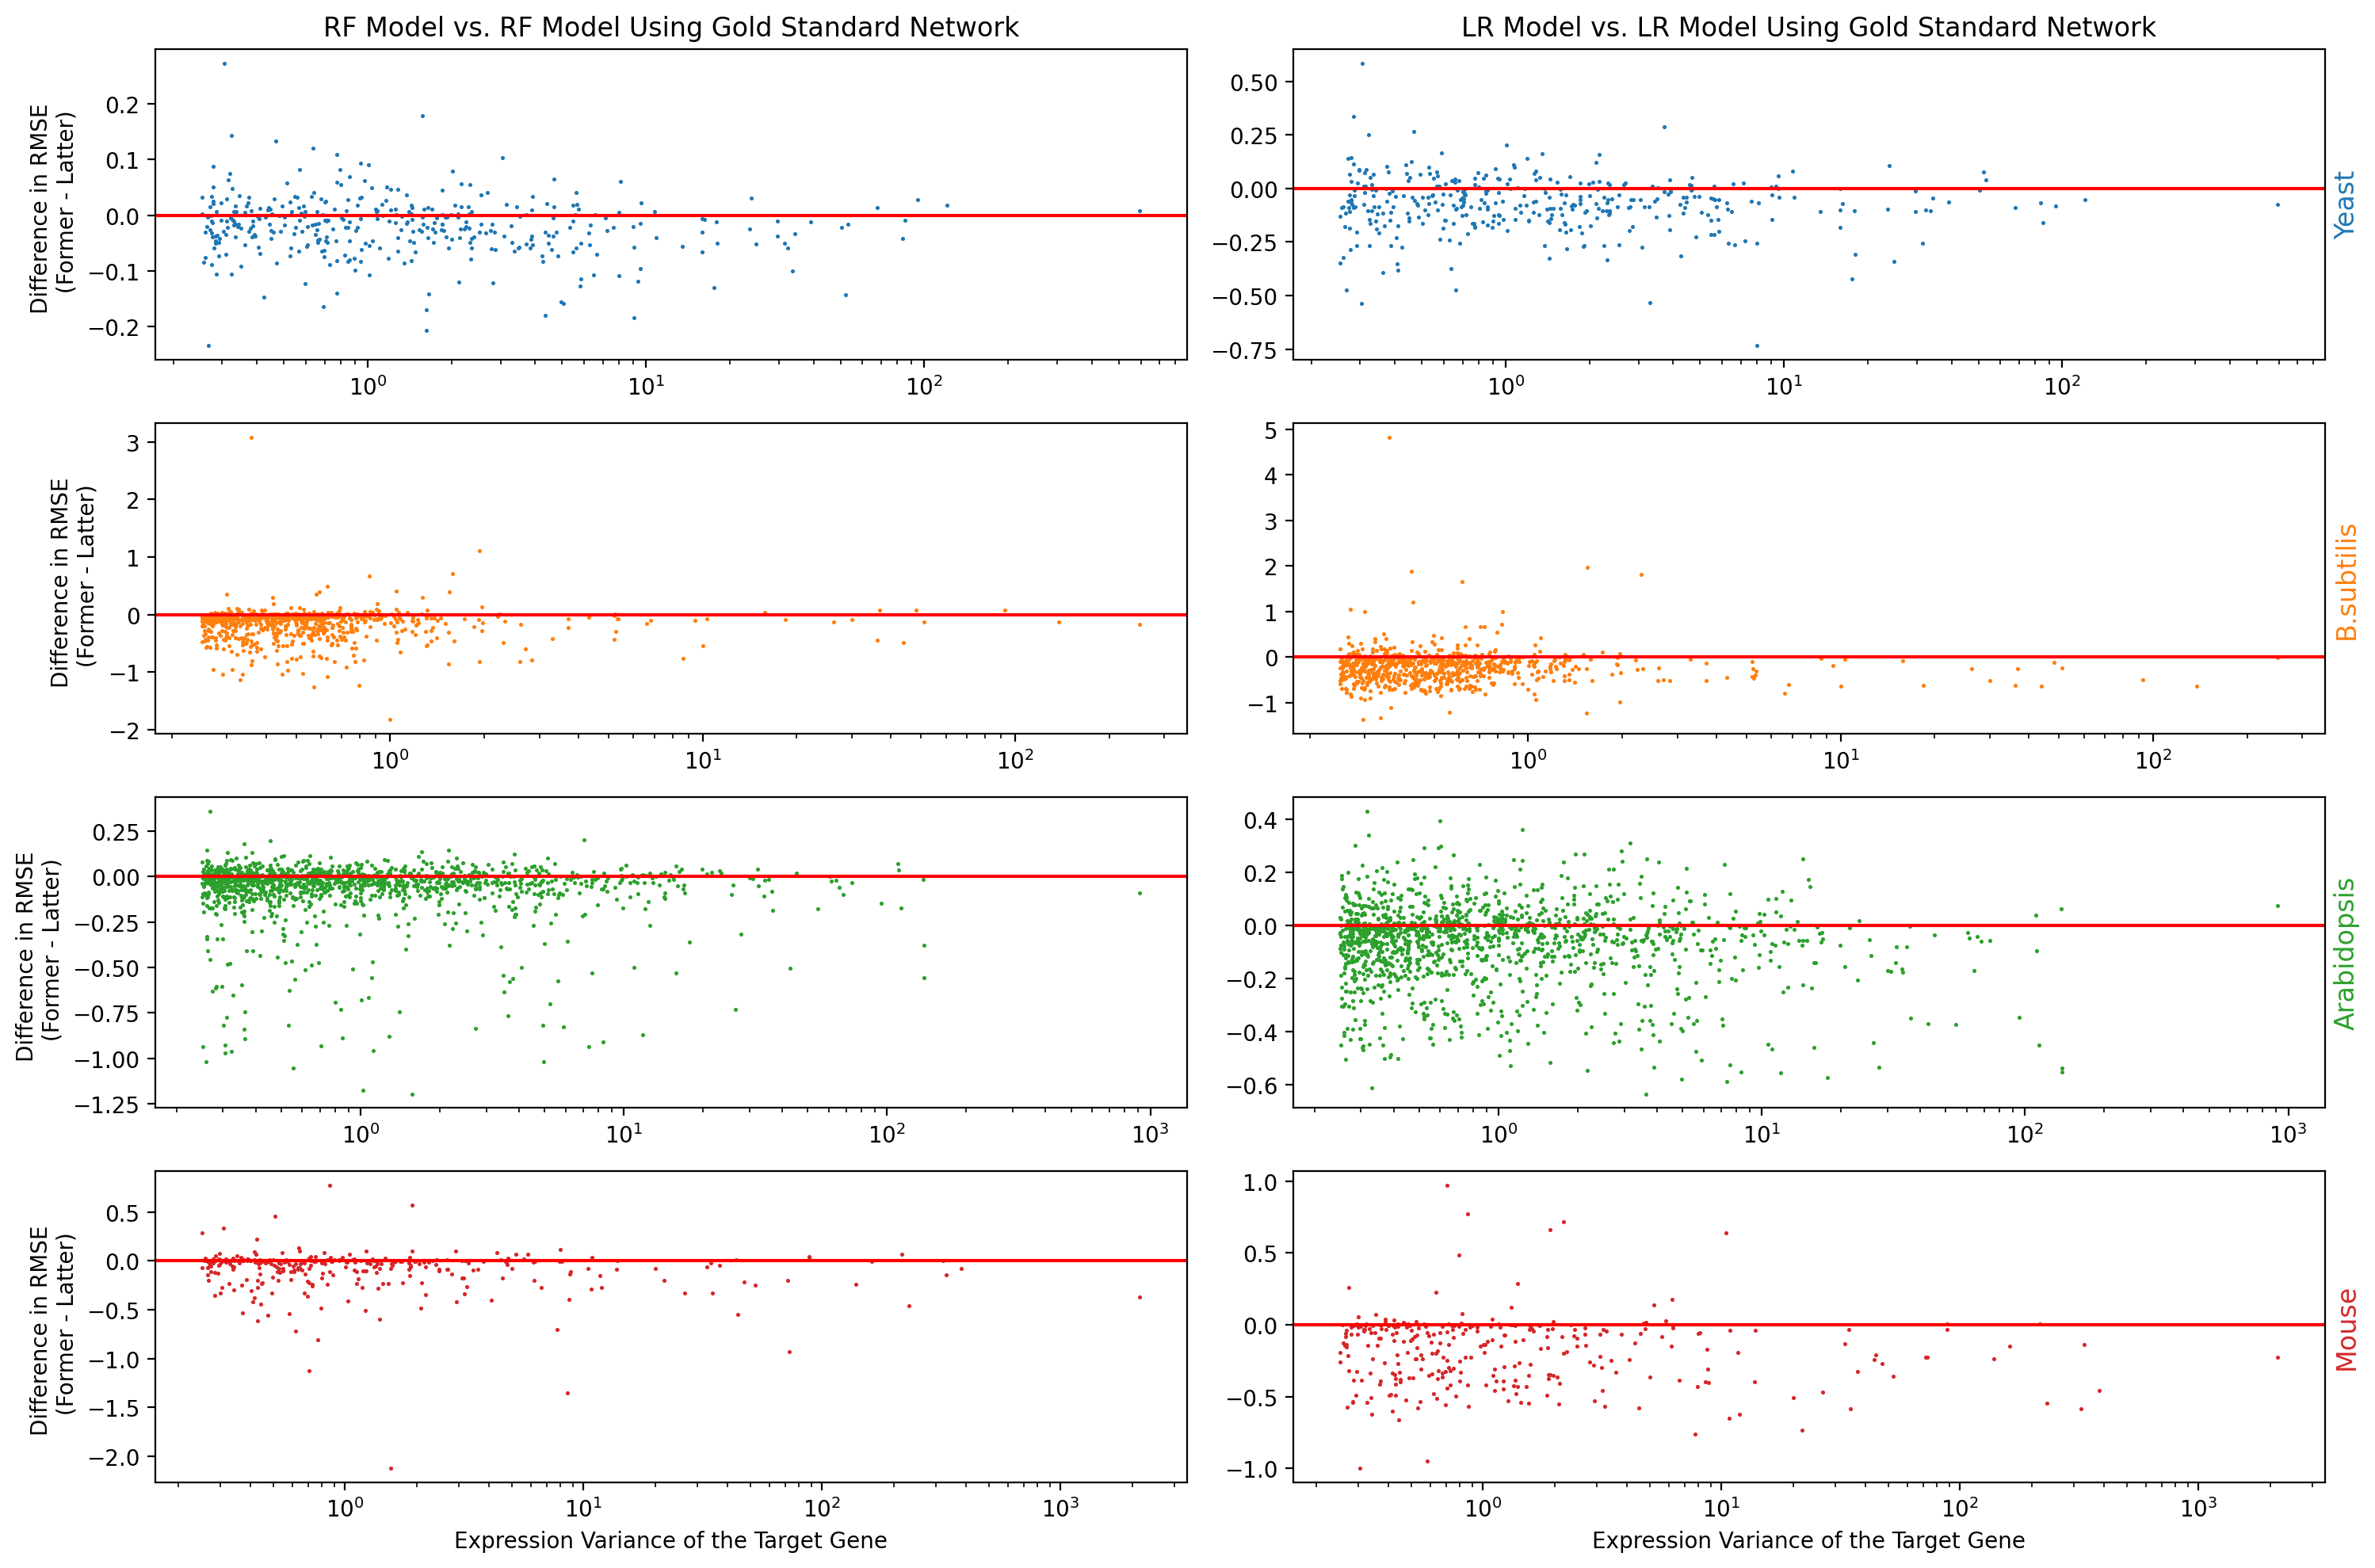

In [4]:
a = 'linear_rmse'
b = 'gs_linear_rmse'
c = 'rf_rmse'
d = 'gs_rf_rmse'

fig, axs = plt.subplots(4, 2, figsize=(15, 10))

for i in range(4):
    df = filtered_df_list[i]
    diff = (df[c] - df[d])/df['test_std']
    axs[i, 0].scatter(df['test_var'], diff, s=0.7, color=plt.cm.tab10(i))
    # plt.scatter(range(len(diff)),diff, s=0.2)
    axs[i, 0].axhline(y=0, color='r', linestyle='-')
    axs[i, 0].set_xscale('log')
    
    diff = (df[a] - df[b])/df['test_std']
    axs[i, 1].scatter(df['test_var'], diff, s=0.7, color=plt.cm.tab10(i))
    # plt.scatter(range(len(diff)),diff, s=0.2)
    axs[i, 1].axhline(y=0, color='r', linestyle='-')
    axs[i, 1].set_xscale('log')
    
for i in range(4):
    axs[i, 0].set(ylabel='Difference in RMSE \n (Former - Latter)')
    axs[i, 1].set_ylabel(species_names[i], color=plt.cm.tab10(i), size='large')
    axs[i, 1].yaxis.set_label_position("right")

axs[3, 0].set(xlabel='Expression Variance of the Target Gene')
axs[3, 1].set(xlabel='Expression Variance of the Target Gene')

axs[0, 0].set_title('RF Model vs. RF Model Using Gold Standard Network')
axs[0, 1].set_title('LR Model vs. LR Model Using Gold Standard Network')
fig.tight_layout()
fig.savefig('./plot_output/all_v_gs.pdf', format='pdf', dpi=300)

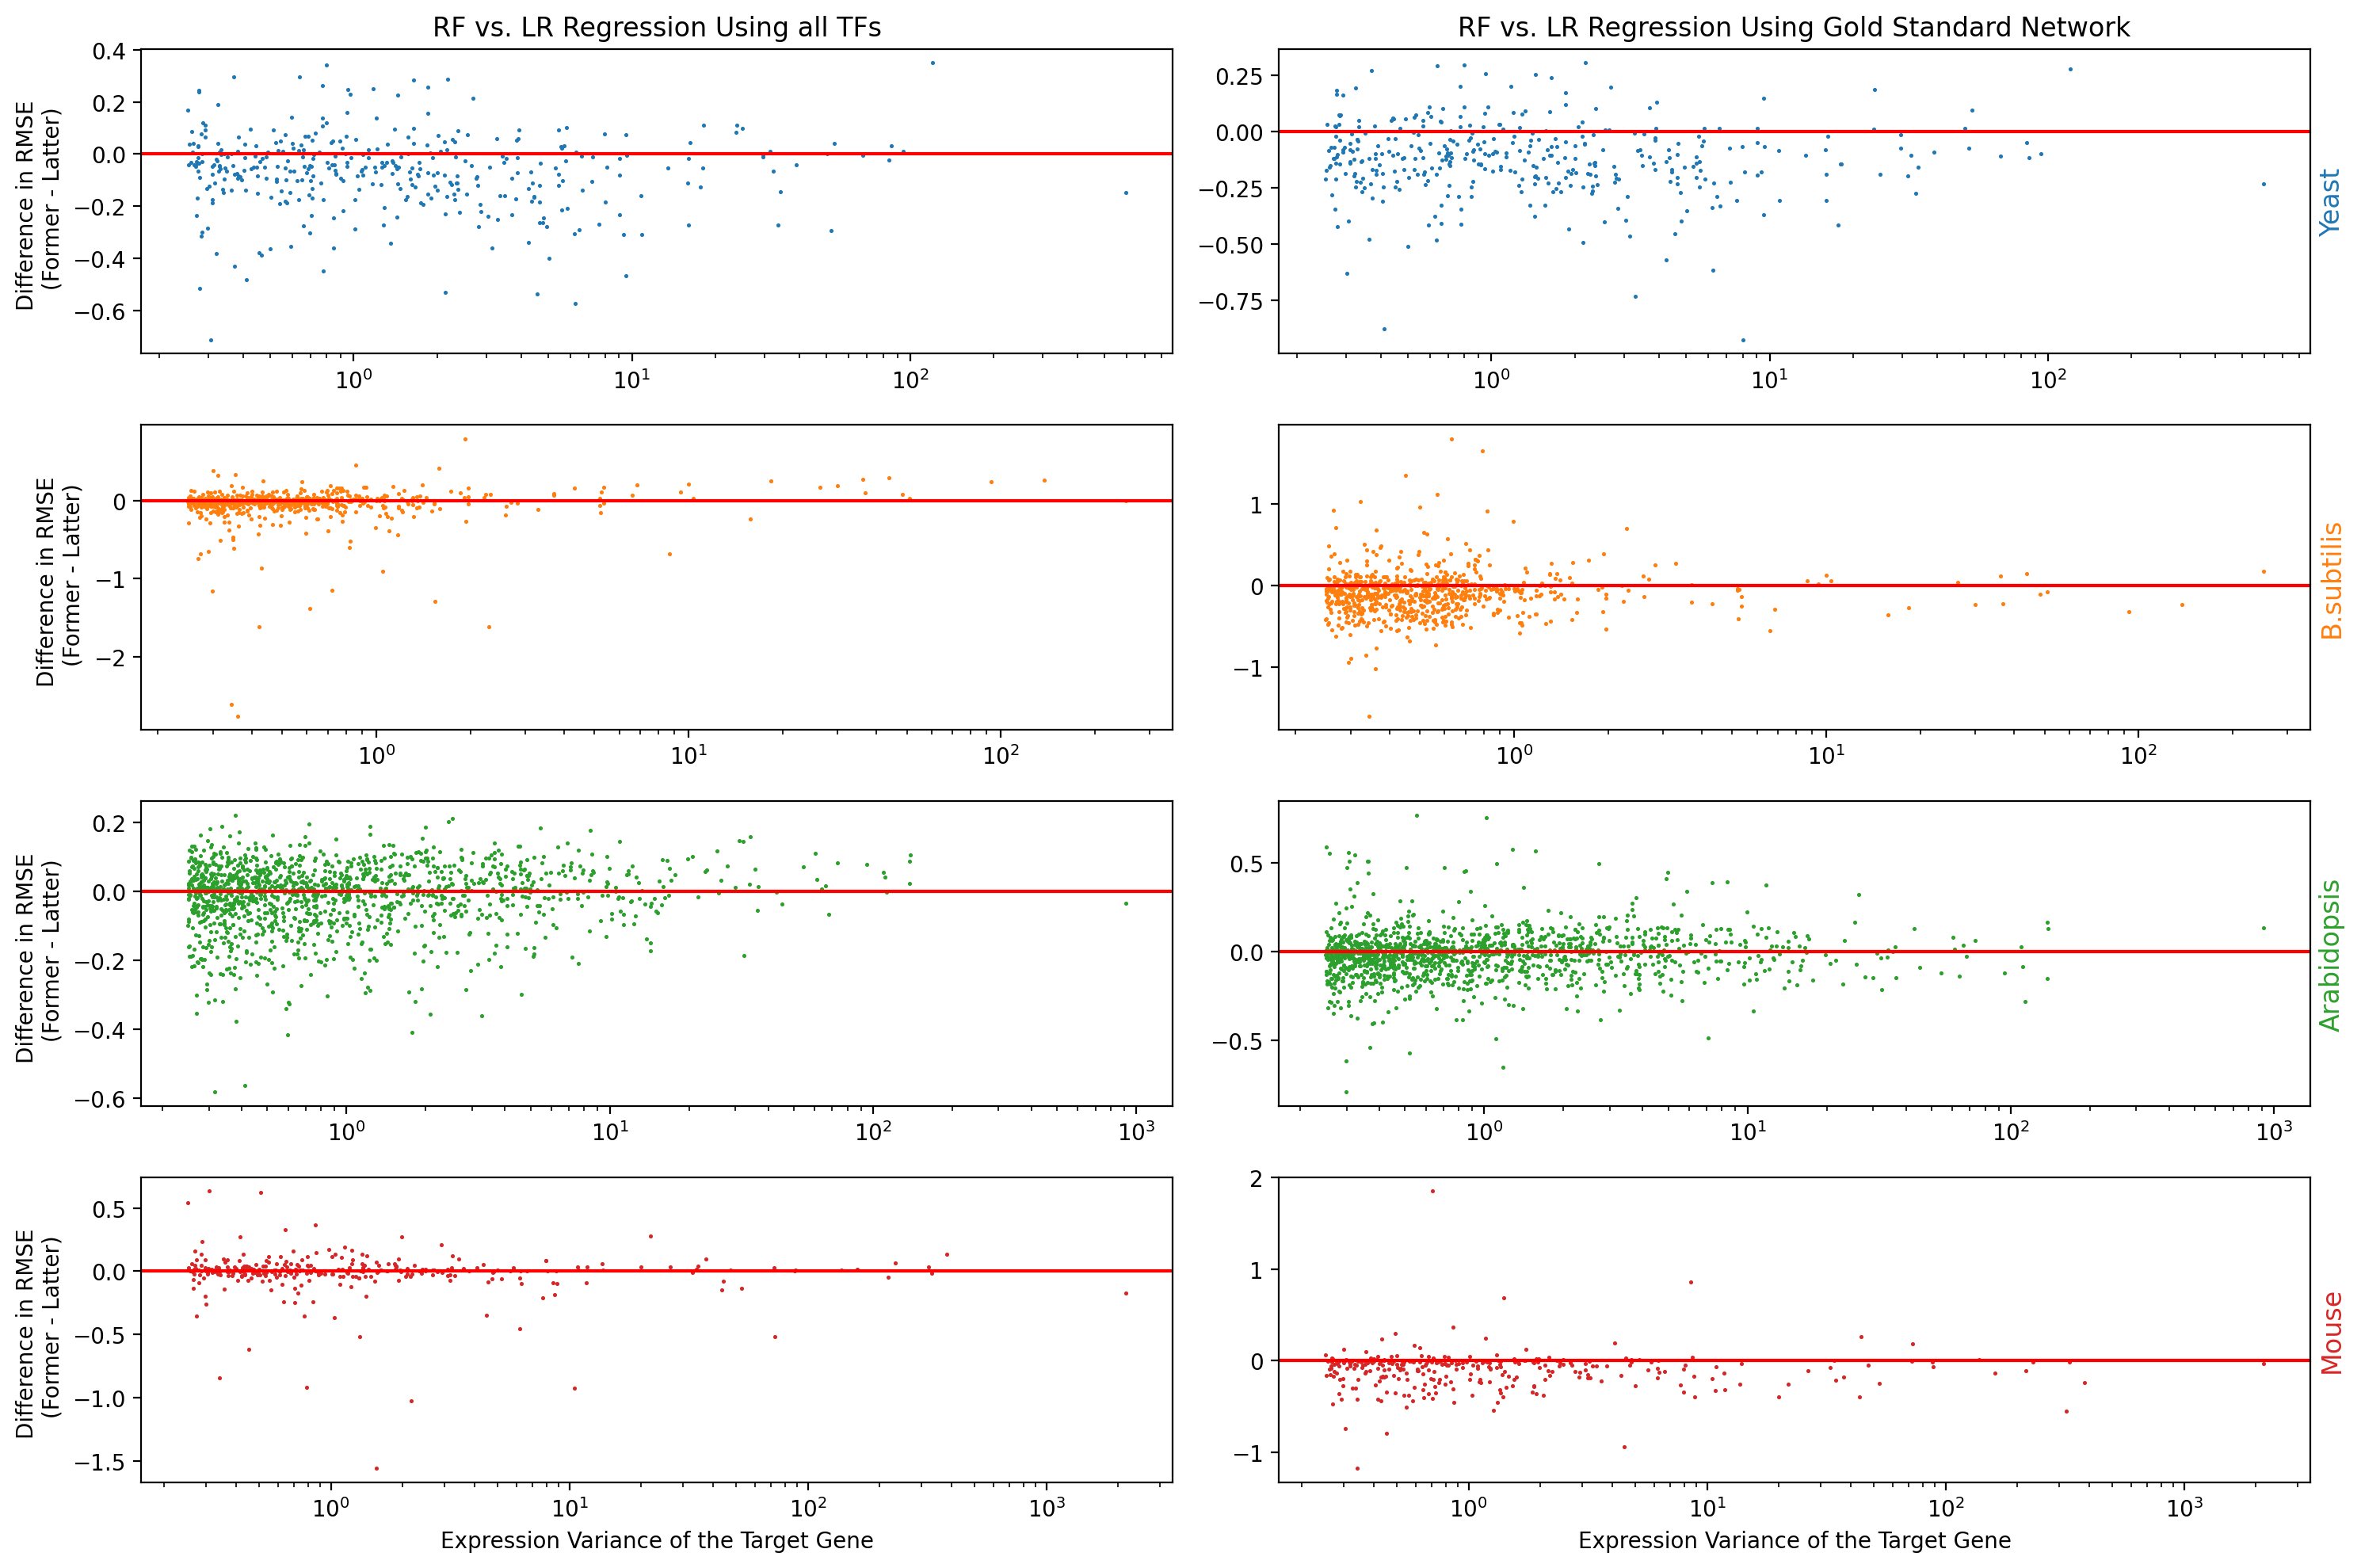

In [5]:
a = 'rf_rmse'
b = 'linear_rmse'
c = 'gs_rf_rmse'
d = 'gs_linear_rmse'

fig, axs = plt.subplots(4, 2, figsize=(15, 10))

for i in range(4):
    df = filtered_df_list[i]
    diff = df[a] - df[b]
    diff = (df[a] - df[b])/df['test_std']
    axs[i, 0].scatter(df['test_var'], diff, s=0.7, color=plt.cm.tab10(i))
    # plt.scatter(range(len(diff)),diff, s=0.2)
    axs[i, 0].axhline(y=0, color='r', linestyle='-')
    axs[i, 0].set_xscale('log')
    
    diff = df[c] - df[d]
    diff = (df[c] - df[d])/df['test_std']
    axs[i, 1].scatter(df['test_var'], diff, s=0.7, color=plt.cm.tab10(i))
    # plt.scatter(range(len(diff)),diff, s=0.2)
    axs[i, 1].axhline(y=0, color='r', linestyle='-')
    axs[i, 1].set_xscale('log')
    
for i in range(4):
    axs[i, 0].set(ylabel='Difference in RMSE \n (Former - Latter)')
    axs[i, 1].set_ylabel(species_names[i], color=plt.cm.tab10(i), size='large')
    axs[i, 1].yaxis.set_label_position("right")

axs[3, 0].set(xlabel='Expression Variance of the Target Gene')
axs[3, 1].set(xlabel='Expression Variance of the Target Gene')

axs[0, 0].set_title('RF vs. LR Regression Using all TFs')
axs[0, 1].set_title('RF vs. LR Regression Using Gold Standard Network')
fig.tight_layout()
fig.savefig('./plot_output/rf_v_lr.pdf', format='pdf', dpi=300)

In [7]:
model_name_dict = {
    'rf_rmse': 'RF with all TFs',
    'linear_rmse': 'LR with all TFs',
    'gs_rf_rmse': 'RF with GS network',
    'gs_linear_rmse': 'LR with GS network',
    'rf_with_top_features_rmse': 'RF with top TFs',
    'linear_with_top_features_rmse': 'LR with top TFs',
    'rf_efron_rmse': 'RF with Efron TFs(half shrink)',
    'rf_efron_rmse_90th': 'RF with Efron TFs(90%% shrink)',
    'rf_efron_complementary_rmse': 'RF with Complementary Efron TFs(half shrink)',
    'rf_efron_complementary_rmse_90th': 'RF with Complementary Efron TFs(90%% shrink)',
}

In [ ]:
'rf_efron_rmse', 'rf_rmse'),
 ('rf_efron_rmse', 'gs_rf_rmse'),
 ('rf_efron_rmse', 'rf_with_top_features_rmse'),
 ('rf_efron_rmse', 'rf_efron_complementary_rmse'),
 ('rf_efron_rmse', 'rf_efron_rmse_90th')]

In [6]:
model_compare_combs = [('rf_rmse', 'gs_rf_rmse'),
 ('linear_rmse', 'gs_linear_rmse'),
 ('rf_rmse', 'linear_rmse'),
 ('gs_rf_rmse', 'gs_linear_rmse'),
 ('rf_rmse', 'gs_linear_rmse'),
 ('gs_rf_rmse', 'linear_rmse')]

In [7]:
top_feature_model_compare_combs = [('rf_with_top_features_rmse', 'rf_rmse'),
 ('rf_with_top_features_rmse', 'gs_rf_rmse'),
 ('linear_with_top_features_rmse', 'linear_rmse'),
 ('linear_with_top_features_rmse', 'gs_linear_rmse')]

In [8]:
efron_model_compare_combs = [('rf_efron_rmse', 'rf_rmse'),
 ('rf_efron_rmse', 'gs_rf_rmse'),
 ('rf_efron_rmse', 'rf_with_top_features_rmse'),
 ('rf_efron_rmse', 'rf_efron_complementary_rmse'),
 ('rf_efron_rmse', 'rf_efron_rmse_90th'),
 ('rf_efron_rmse_90th', 'rf_efron_complementary_rmse_90th')
 ]

In [12]:
paired_ttest_df = pd.DataFrame(index=range(len(model_compare_combs)))
paired_ttest_df['Model_A'] = [model_name_dict[key] for key in np.array(model_compare_combs)[:, 0]]
paired_ttest_df['Model_B'] = [model_name_dict[key] for key in np.array(model_compare_combs)[:, 1]]

res_df = filtered_df_list[3]

mean_list = []
ci_list = []
p_list = []

stats_res = stats.ttest_rel(res_df['linear_rmse'], res_df['gs_linear_rmse'])
for a, b in model_compare_combs:
    t_res = stats.ttest_rel(res_df[a], res_df[b])
    ci_res = t_res.confidence_interval()
    mean = (res_df[a] - res_df[b]).mean()
    mean_list.append(f'{mean:.3}')
    ci_list.append('('+f'{ci_res[0]:.3}'+', '+f'{ci_res[1]:.3}'+')')
    p_list.append(f'{t_res[1]:.3}')

paired_ttest_df['Mean Difference'] = mean_list
paired_ttest_df['95% Confidence Interval of Difference'] = ci_list
paired_ttest_df['p-value'] = p_list
paired_ttest_df.to_csv('./plot_output/ttest_res.csv', index=False)
paired_ttest_df

,Model_A,Model_B,Mean Difference,95% Confidence Interval of Difference,p-value
0,RF with all TFs,RF with GS network,-0.277,"(-0.416, -0.139)",9.82e-05
1,LR with all TFs,LR with GS network,-0.416,"(-0.55, -0.281)",3.64e-09
2,RF with all TFs,LR with all TFs,-0.0594,"(-0.129, 0.0103)",0.0945
3,RF with GS network,LR with GS network,-0.198,"(-0.281, -0.114)",4.41e-06
4,RF with all TFs,LR with GS network,-0.475,"(-0.637, -0.313)",1.82e-08
5,RF with GS network,LR with all TFs,0.218,"(0.118, 0.319)",2.6e-05


In [9]:
paired_ttest_df = pd.DataFrame(index=range(len(top_feature_model_compare_combs)))
paired_ttest_df['Model_A'] = [model_name_dict[key] for key in np.array(top_feature_model_compare_combs)[:, 0]]
paired_ttest_df['Model_B'] = [model_name_dict[key] for key in np.array(top_feature_model_compare_combs)[:, 1]]

res_df = filtered_df_list[3]

mean_list = []
ci_list = []
p_list = []

stats_res = stats.ttest_rel(res_df['linear_rmse'], res_df['gs_linear_rmse'])
for a, b in top_feature_model_compare_combs:
    t_res = stats.ttest_rel(res_df[a], res_df[b])
    ci_res = t_res.confidence_interval()
    mean = (res_df[a] - res_df[b]).mean()
    mean_list.append(f'{mean:.3}')
    ci_list.append('('+f'{ci_res[0]:.3}'+', '+f'{ci_res[1]:.3}'+')')
    p_list.append(f'{t_res[1]:.3}')

paired_ttest_df['Mean Difference'] = mean_list
paired_ttest_df['95% Confidence Interval of Difference'] = ci_list
paired_ttest_df['p-value'] = p_list
paired_ttest_df.to_csv('./plot_output/ttest_res.csv', index=False)
paired_ttest_df

,Model_A,Model_B,Mean Difference,95% Confidence Interval of Difference,p-value
0,RF with top TFs,RF with all TFs,0.107,"(0.0276, 0.187)",0.00849
1,RF with top TFs,RF with GS network,-0.17,"(-0.258, -0.0824)",0.000162
2,LR with top TFs,LR with all TFs,0.0413,"(-0.0379, 0.12)",0.305
3,LR with top TFs,LR with GS network,-0.374,"(-0.531, -0.217)",4.11e-06


In [10]:
paired_ttest_df = pd.DataFrame(index=range(len(efron_model_compare_combs)))
paired_ttest_df['Model_A'] = [model_name_dict[key] for key in np.array(efron_model_compare_combs)[:, 0]]
paired_ttest_df['Model_B'] = [model_name_dict[key] for key in np.array(efron_model_compare_combs)[:, 1]]

res_df = filtered_df_list[3]
for res_df, name in zip(filtered_df_list, species_names):

    mean_list = []
    ci_list = []
    p_list = []

    stats_res = stats.ttest_rel(res_df['linear_rmse'], res_df['gs_linear_rmse'])
    for a, b in efron_model_compare_combs:
        t_res = stats.ttest_rel(res_df[a], res_df[b])
        ci_res = t_res.confidence_interval()
        mean = (res_df[a] - res_df[b]).mean()
        mean_list.append(f'{mean:.3}')
        ci_list.append('('+f'{ci_res[0]:.3}'+', '+f'{ci_res[1]:.3}'+')')
        p_list.append(f'{t_res[1]:.3}')

    paired_ttest_df['Mean Difference'] = mean_list
    paired_ttest_df['95% Confidence Interval of Difference'] = ci_list
    paired_ttest_df['p-value'] = p_list
    paired_ttest_df.to_csv('./plot_output/'+name+'_efron_ttest_res.csv', index=False)
    print('======================================')
    print(name)
    print(paired_ttest_df)

Yeast
                          Model_A  \
0  RF with Efron TFs(half shrink)   
1  RF with Efron TFs(half shrink)   
2  RF with Efron TFs(half shrink)   
3  RF with Efron TFs(half shrink)   
4  RF with Efron TFs(half shrink)   
5  RF with Efron TFs(90%% shrink)   

                                        Model_B Mean Difference  \
0                               RF with all TFs         0.00273   
1                            RF with GS network         -0.0421   
2                               RF with top TFs         -0.0538   
3  RF with Complementary Efron TFs(half shrink)          -0.017   
4                RF with Efron TFs(90%% shrink)        -0.00794   
5  RF with Complementary Efron TFs(90%% shrink)         -0.0177   

  95% Confidence Interval of Difference p-value  
0                        (-0.15, 0.155)   0.972  
1                        (-0.195, 0.11)   0.587  
2                       (-0.212, 0.104)   0.504  
3                   (-0.0345, 0.000476)  0.0565  
4             